# Exploratory Data Analysis (EDA)

This notebook contains the exploratory data analysis (EDA) process for the dataset. All explanations of EDA have been removed for clarity and simplicity, and the content is now presented in English.

## Lab 5: Exploratory Data Analysis

### Use Hugging Face to download the dataset 🤗

In [16]:
import ast
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rcParams

In [17]:
# !hf download celesca/election_results_2569 --repo-type dataset --local-dir ./

In [18]:
import zipfile
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [19]:
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

data_folders = ["all_constituency", "area", "party", "partylist", "referendum", "seat", "winner"]

for folder in data_folders:
    folder_path = Path(folder)
    if folder_path.exists():
        for csv_file in folder_path.glob("*.csv"):
            shutil.copy(csv_file, data_dir / csv_file.name)
            print(f"Copied {csv_file.name} to data/")

Copied areas.csv to data/
Copied partyStandings.csv to data/
Copied party_list_top2.csv to data/
Copied map.csv to data/
Copied seat500.csv to data/
Copied winner.csv to data/


In [20]:
for folder in data_folders:
    folder_path = Path(folder)
    if folder_path.exists():
        shutil.rmtree(folder_path)
        print(f"Removed {folder} directory")

# if Path("data.zip").exists():
#     Path("data.zip").unlink()
#     print("Removed data.zip")

print("\nCSV files are now in the 'data/' directory")

Removed all_constituency directory
Removed area directory
Removed party directory
Removed partylist directory
Removed referendum directory
Removed seat directory
Removed winner directory

CSV files are now in the 'data/' directory


## Thai Font in Matplotlib

Download Thai font and place it in your working directory.

In [21]:
font_path = "THSarabunNew.ttf"

In [22]:
font_path = "THSarabunNew.ttf"
font_manager.fontManager.addfont(font_path)
rcParams["font.family"] = "TH Sarabun New"
thai_font = font_manager.FontProperties(fname=font_path)

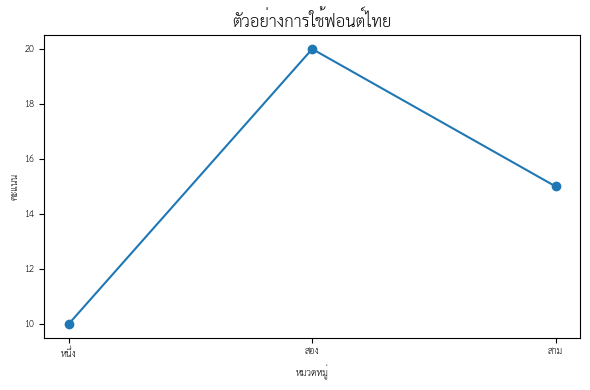

In [23]:
plt.figure(figsize=(6, 4))
plt.title("ตัวอย่างการใช้ฟอนต์ไทย", fontproperties=thai_font, fontsize=18)
plt.xlabel("หมวดหมู่", fontproperties=thai_font)
plt.ylabel("คะแนน", fontproperties=thai_font)

plt.plot([1, 2, 3], [10, 20, 15], marker="o")
plt.xticks([1, 2, 3], ["หนึ่ง", "สอง", "สาม"], fontproperties=thai_font)
plt.yticks(fontproperties=thai_font)

plt.tight_layout()
plt.show()

# Context

## 2026 Thai General Election

The 2026 Thai general election was held on 8 February 2026 to choose members of Thailand’s House of Representatives. The election was triggered after the House of Representatives was dissolved on 12 December 2025. All 500 seats in the House were up for election.

The electoral system used two methods:
- 400 seats elected from constituencies.
- 100 seats allocated by party-list proportional representation.

The election was held alongside a referendum to decide whether to begin drafting a new constitution to replace the current 2017 charter.

# EDA

## Data understanding

- `winner`: constituency election results. Each row is one constituency winner, with party and vote summary fields.
- `party_standings`: overall party standings. Each row is one party with total votes and seat counts.
- `seat500`: 500-seat allocation table. Each row is one seat record linked to a party code.
- `party_list_top2`: top-2 party-list result per constituency. Each row is one constituency with the top two parties and vote shares.
- `map_data`: map-ready referendum and geography fields. Each row is one constituency area used for mapping.

### Unit of analysis

- `winner`: constituency-level.
- `party_standings`: party-level.
- `seat500`: seat-level.
- `party_list_top2`: constituency-level.
- `map_data`: constituency-level (and can be grouped to province-level by `provinceName`).

### Key IDs and join keys

- `id`: primary row identifier in each table, but meaning changes by table (party ID in `party_standings`, constituency ID in `winner`, `party_list_top2`, and `map_data`).
- `partyCode`: party key in `seat500`.
- `provinceName`: geographic key for province-level grouping and joins.
- Party joins: use `party_standings.id` ↔ `seat500.partyCode`; in `winner`, the winner party code is stored in `partyWinner`.

# Data quality checks

## Table overview

In [24]:
data_dir = Path("data")
file_map = {
    "winner": "winner.csv",
    "party_standings": "partyStandings.csv",
    "seat500": "seat500.csv",
    "party_list_top2": "party_list_top2.csv",
    "map_data": "map.csv",
}

dfs = {name: pd.read_csv(data_dir / file_name) for name, file_name in file_map.items()}

overview = pd.DataFrame(
    [{"table": name, "rows": frame.shape[0], "cols": frame.shape[1]} for name, frame in dfs.items()]
)
overview

,table,rows,cols
0,winner,400,8
1,party_standings,60,8
2,seat500,500,7
3,party_list_top2,400,7
4,map_data,400,7


## Missing values by table and column

In [25]:
missing_by_table = []
missing_by_column = []

for table_name, frame in dfs.items():
    missing_count = frame.isna().sum()
    missing_pct = frame.isna().mean().mul(100)

    missing_by_table.append(
        {
            "table": table_name,
            "rows": len(frame),
            "total_missing_cells": int(missing_count.sum()),
            "missing_cell_pct": round(frame.isna().mean().mean() * 100, 2),
        }
    )

    for column in frame.columns:
        missing_by_column.append(
            {
                "table": table_name,
                "column": column,
                "missing_count": int(missing_count[column]),
                "missing_pct": round(float(missing_pct[column]), 2),
            }
        )

pd.DataFrame(missing_by_table).sort_values("total_missing_cells", ascending=False)

,table,rows,total_missing_cells,missing_cell_pct
0,winner,400,0,0.0
1,party_standings,60,0,0.0
2,seat500,500,0,0.0
3,party_list_top2,400,0,0.0
4,map_data,400,0,0.0


In [26]:
missing_columns_df = pd.DataFrame(missing_by_column)
missing_columns_df = missing_columns_df.sort_values(
    ["table", "missing_count", "missing_pct"],
    ascending=[True, False, False],
)
missing_columns_df

,table,column,missing_count,missing_pct
30,map_data,id,0,0.0
31,map_data,name,0,0.0
32,map_data,provinceId,0,0.0
33,map_data,number,0,0.0
34,map_data,provinceName,0,0.0
35,map_data,referendums,0,0.0
36,map_data,provinceId_key,0,0.0
23,party_list_top2,id,0,0.0
24,party_list_top2,name,0,0.0
25,party_list_top2,provinceId,0,0.0


## Duplicates and key uniqueness

In [27]:
id_column_map = {
    "winner": "id",
    "party_standings": "id",
    "seat500": "index",
    "party_list_top2": "id",
    "map_data": "id",
}

duplicate_rows = []
for table_name, frame in dfs.items():
    id_column = id_column_map.get(table_name)
    duplicate_rows.append(
        {
            "table": table_name,
            "duplicate_rows": int(frame.duplicated().sum()),
            "id_column": id_column,
            "duplicate_ids": int(frame.duplicated(subset=[id_column]).sum())
            if id_column in frame.columns
            else None,
        }
    )

pd.DataFrame(duplicate_rows).sort_values("duplicate_rows", ascending=False)

,table,duplicate_rows,id_column,duplicate_ids
0,winner,0,id,0
1,party_standings,0,id,0
2,seat500,0,index,0
3,party_list_top2,0,id,0
4,map_data,0,id,0


## JSON-like field parsing checks

In [28]:
json_targets = {
    "winner": "candidates",
    "party_list_top2": "parties",
    "map_data": "referendums",
}


def try_parse_json_like(value):
    if pd.isna(value):
        return None, False
    if isinstance(value, (list, dict)):
        return value, True
    try:
        return ast.literal_eval(str(value)), True
    except (ValueError, SyntaxError):
        return None, False


parse_rows = []
for table_name, column_name in json_targets.items():
    frame = dfs[table_name]
    series = frame[column_name]

    non_null = series.notna().sum()
    parse_ok = series.apply(lambda x: try_parse_json_like(x)[1]).sum()
    parse_fail = int(non_null - parse_ok)

    parse_rows.append(
        {
            "table": table_name,
            "column": column_name,
            "rows": len(series),
            "non_null_rows": int(non_null),
            "parse_fail_rows": parse_fail,
            "parse_fail_pct_of_non_null": round((parse_fail / non_null) * 100, 2)
            if non_null
            else 0.0,
        }
    )

pd.DataFrame(parse_rows)

,table,column,rows,non_null_rows,parse_fail_rows,parse_fail_pct_of_non_null
0,winner,candidates,400,400,0,0.0
1,party_list_top2,parties,400,400,0,0.0
2,map_data,referendums,400,400,0,0.0


## Numeric-like object columns

In [29]:
numeric_like_rows = []
threshold = 0.8

for table_name, frame in dfs.items():
    for column in frame.columns:
        if frame[column].dtype != "object":
            continue

        raw = frame[column]
        non_null = raw.dropna().astype(str).str.strip()
        non_empty = non_null[non_null != ""]

        if len(non_empty) == 0:
            continue

        cleaned = non_empty.str.replace(",", "", regex=False)
        parsed = pd.to_numeric(cleaned, errors="coerce")
        numeric_ratio = parsed.notna().mean()

        if numeric_ratio >= threshold:
            numeric_like_rows.append(
                {
                    "table": table_name,
                    "column": column,
                    "dtype": str(frame[column].dtype),
                    "non_empty_rows": int(len(non_empty)),
                    "numeric_like_ratio": round(float(numeric_ratio), 3),
                }
            )

pd.DataFrame(numeric_like_rows).sort_values(
    ["numeric_like_ratio", "table", "column"],
    ascending=[False, True, True],
) if numeric_like_rows else pd.DataFrame(
    columns=["table", "column", "dtype", "non_empty_rows", "numeric_like_ratio"]
)

,table,column,dtype,non_empty_rows,numeric_like_ratio


## Party name consistency across tables

In [30]:
party_name_sources = {
    "party_standings.partyName": set(
        dfs["party_standings"]["partyName"].dropna().astype(str).str.strip()
    ),
    "seat500.partyName": set(dfs["seat500"]["partyName"].dropna().astype(str).str.strip()),
}

winner_party_names = set()
for raw in dfs["winner"]["candidates"].dropna():
    parsed, ok = try_parse_json_like(raw)
    if not ok or not isinstance(parsed, list):
        continue
    for item in parsed:
        if isinstance(item, dict):
            party = item.get("party")
            if isinstance(party, dict) and party.get("name"):
                winner_party_names.add(str(party["name"]).strip())

party_list_names = set()
for raw in dfs["party_list_top2"]["parties"].dropna():
    parsed, ok = try_parse_json_like(raw)
    if not ok or not isinstance(parsed, list):
        continue
    for item in parsed:
        if isinstance(item, dict):
            name = item.get("name")
            if name:
                party_list_names.add(str(name).strip())

party_name_sources["winner.candidates.party.name"] = winner_party_names
party_name_sources["party_list_top2.parties.name"] = party_list_names

all_party_names = sorted(set().union(*party_name_sources.values()))
presence_df = pd.DataFrame({"partyName": all_party_names})
for source_name, names in party_name_sources.items():
    presence_df[source_name] = presence_df["partyName"].isin(names)

presence_df[presence_df.drop(columns=["partyName"]).sum(axis=1) < len(party_name_sources)]

,partyName,party_standings.partyName,seat500.partyName,winner.candidates.party.name,party_list_top2.parties.name
0,พรรคกรีน,True,False,False,False
2,พรรคก้าวอิสระ,True,False,False,False
3,พรรคครูไทยเพื่อประชาชน,True,False,False,False
4,พรรคคลองไทย,True,False,False,False
5,พรรคความหวังใหม่,True,False,False,False
6,พรรคทางเลือกใหม่,True,True,False,False
7,พรรคท้องที่ไทย,True,False,False,False
8,พรรคประชากรไทย,True,False,False,False
12,พรรคประชาธิปไตยใหม่,True,True,False,False
13,พรรคประชาอาสาชาติ,True,False,False,False


## Descriptive election profile

### Build constituency and party-list profiles

In [31]:
winner_frame = dfs["winner"].copy()
party_frame = dfs["party_standings"].copy()
party_list_frame = dfs["party_list_top2"].copy()
map_frame = dfs["map_data"].copy()


def to_records(value):
    parsed, ok = try_parse_json_like(value)
    if ok and isinstance(parsed, list):
        return parsed
    return []


winner_rows = []
for _, row in winner_frame.iterrows():
    candidates = to_records(row.get("candidates"))
    candidate_rows = []
    for candidate in candidates:
        if not isinstance(candidate, dict):
            continue
        candidate_rows.append(
            {
                "rank": candidate.get("rank"),
                "totalVotes": candidate.get("totalVotes"),
                "percent": candidate.get("percent"),
            }
        )

    candidate_df = pd.DataFrame(candidate_rows)
    if candidate_df.empty:
        winner_rows.append(
            {
                "id": row.get("id"),
                "provinceName": row.get("provinceName"),
                "winner_votes": pd.NA,
                "winner_percent": pd.NA,
                "runner_up_votes": pd.NA,
                "runner_up_percent": pd.NA,
                "vote_margin_votes": pd.NA,
                "vote_margin_pct_points": pd.NA,
                "constituency_total_votes": pd.NA,
            }
        )
        continue

    candidate_df["totalVotes"] = pd.to_numeric(candidate_df["totalVotes"], errors="coerce")
    candidate_df["percent"] = pd.to_numeric(candidate_df["percent"], errors="coerce")
    candidate_df["rank"] = pd.to_numeric(candidate_df["rank"], errors="coerce")

    ranked = candidate_df.dropna(subset=["rank"]).sort_values("rank")
    if ranked.empty:
        ranked = candidate_df.sort_values("totalVotes", ascending=False)

    winner_candidate = ranked.iloc[0] if len(ranked) >= 1 else pd.Series(dtype="object")
    runner_candidate = ranked.iloc[1] if len(ranked) >= 2 else pd.Series(dtype="object")

    winner_votes = pd.to_numeric(winner_candidate.get("totalVotes"), errors="coerce")
    winner_percent = pd.to_numeric(winner_candidate.get("percent"), errors="coerce")
    runner_votes = pd.to_numeric(runner_candidate.get("totalVotes"), errors="coerce")
    runner_percent = pd.to_numeric(runner_candidate.get("percent"), errors="coerce")

    winner_rows.append(
        {
            "id": row.get("id"),
            "provinceName": row.get("provinceName"),
            "winner_votes": winner_votes,
            "winner_percent": winner_percent,
            "runner_up_votes": runner_votes,
            "runner_up_percent": runner_percent,
            "vote_margin_votes": winner_votes - runner_votes,
            "vote_margin_pct_points": winner_percent - runner_percent,
            "constituency_total_votes": candidate_df["totalVotes"].sum(min_count=1),
        }
    )

winner_profile = pd.DataFrame(winner_rows)

partylist_rows = []
for _, row in party_list_frame.iterrows():
    parties = to_records(row.get("parties"))
    party_rows = []
    for party in parties:
        if not isinstance(party, dict):
            continue
        party_rows.append(
            {
                "rank": party.get("rank"),
                "totalVotes": party.get("totalVotes"),
                "percent": party.get("percent"),
            }
        )

    party_df = pd.DataFrame(party_rows)
    if party_df.empty:
        partylist_rows.append(
            {
                "id": row.get("id"),
                "partylist_margin_votes": pd.NA,
                "partylist_margin_pct_points": pd.NA,
            }
        )
        continue

    party_df["totalVotes"] = pd.to_numeric(party_df["totalVotes"], errors="coerce")
    party_df["percent"] = pd.to_numeric(party_df["percent"], errors="coerce")
    party_df["rank"] = pd.to_numeric(party_df["rank"], errors="coerce")

    ranked = party_df.dropna(subset=["rank"]).sort_values("rank")
    if ranked.empty:
        ranked = party_df.sort_values("totalVotes", ascending=False)

    top1 = ranked.iloc[0] if len(ranked) >= 1 else pd.Series(dtype="object")
    top2 = ranked.iloc[1] if len(ranked) >= 2 else pd.Series(dtype="object")

    top1_votes = pd.to_numeric(top1.get("totalVotes"), errors="coerce")
    top2_votes = pd.to_numeric(top2.get("totalVotes"), errors="coerce")
    top1_percent = pd.to_numeric(top1.get("percent"), errors="coerce")
    top2_percent = pd.to_numeric(top2.get("percent"), errors="coerce")

    partylist_rows.append(
        {
            "id": row.get("id"),
            "partylist_margin_votes": top1_votes - top2_votes,
            "partylist_margin_pct_points": top1_percent - top2_percent,
        }
    )

partylist_margin_profile = pd.DataFrame(partylist_rows)
referendum_votes = []
for raw in map_frame["referendums"].dropna():
    referendums = to_records(raw)
    for ref in referendums:
        if isinstance(ref, dict):
            referendum_votes.append(pd.to_numeric(ref.get("totalVote"), errors="coerce"))

referendum_total_votes = pd.Series(referendum_votes, dtype="float64").sum(min_count=1)
winner_profile.head()

,id,provinceName,winner_votes,winner_percent,runner_up_votes,runner_up_percent,vote_margin_votes,vote_margin_pct_points,constituency_total_votes
0,26b4aad6-94b3-490a-9390-71636d5e97a4,กรุงเทพมหานคร,32564.0,44.39,14018.0,19.11,18546.0,25.28,60243
1,a4b95b52-2371-4a3e-bc51-6b3381578720,กรุงเทพมหานคร,37055.0,47.08,15002.0,19.06,22053.0,28.02,65677
2,be7ff60c-305b-47b8-a8b6-dd699e5f5d6c,กรุงเทพมหานคร,32753.0,45.07,18263.0,25.13,14490.0,19.94,60727
3,8d1c14af-dbec-46bd-ba6d-b605490e385a,กรุงเทพมหานคร,30477.0,43.33,21776.0,30.96,8701.0,12.37,61994
4,380c6e8c-51e2-4acc-8e3f-7772bdf18ae8,กรุงเทพมหานคร,43394.0,50.07,21113.0,24.36,22281.0,25.71,74085


### Election totals cross-check

In [32]:
seat_total_from_rows = int(len(dfs["seat500"]))
seat_total_from_party = pd.to_numeric(party_frame["totalSeats"], errors="coerce").sum(min_count=1)
constituency_seats = pd.to_numeric(party_frame["constituencySeats"], errors="coerce").sum(
    min_count=1
)
party_list_seats = pd.to_numeric(party_frame["partyListSeats"], errors="coerce").sum(min_count=1)

constituency_votes_total = pd.to_numeric(
    party_frame["totalConstituencyVotes"], errors="coerce"
).sum(min_count=1)
party_list_votes_total = pd.to_numeric(party_frame["totalPartyListVotes"], errors="coerce").sum(
    min_count=1
)
combined_votes_total = constituency_votes_total + party_list_votes_total

winner_constituency_votes_total = pd.to_numeric(
    winner_profile["constituency_total_votes"], errors="coerce"
).sum(min_count=1)

totals_table = pd.DataFrame(
    [
        {"metric": "Total seats (seat500 rows)", "value": seat_total_from_rows},
        {"metric": "Total seats (party standings sum)", "value": seat_total_from_party},
        {"metric": "Constituency seats total", "value": constituency_seats},
        {"metric": "Party-list seats total", "value": party_list_seats},
        {"metric": "Constituency votes total (party standings)", "value": constituency_votes_total},
        {"metric": "Party-list votes total (party standings)", "value": party_list_votes_total},
        {"metric": "Combined votes total", "value": combined_votes_total},
        {
            "metric": "Constituency ballots from winner.candidates (sum)",
            "value": winner_constituency_votes_total,
        },
        {"metric": "Referendum total votes (map.referendums)", "value": referendum_total_votes},
    ]
)

totals_table

,metric,value
0,Total seats (seat500 rows),500.0
1,Total seats (party standings sum),500.0
2,Constituency seats total,400.0
3,Party-list seats total,100.0
4,Constituency votes total (party standings),31874109.0
5,Party-list votes total (party standings),31927648.0
6,Combined votes total,63801757.0
7,Constituency ballots from winner.candidates (sum),28602136.0
8,Referendum total votes (map.referendums),33354794.0


### Distribution summaries and histograms

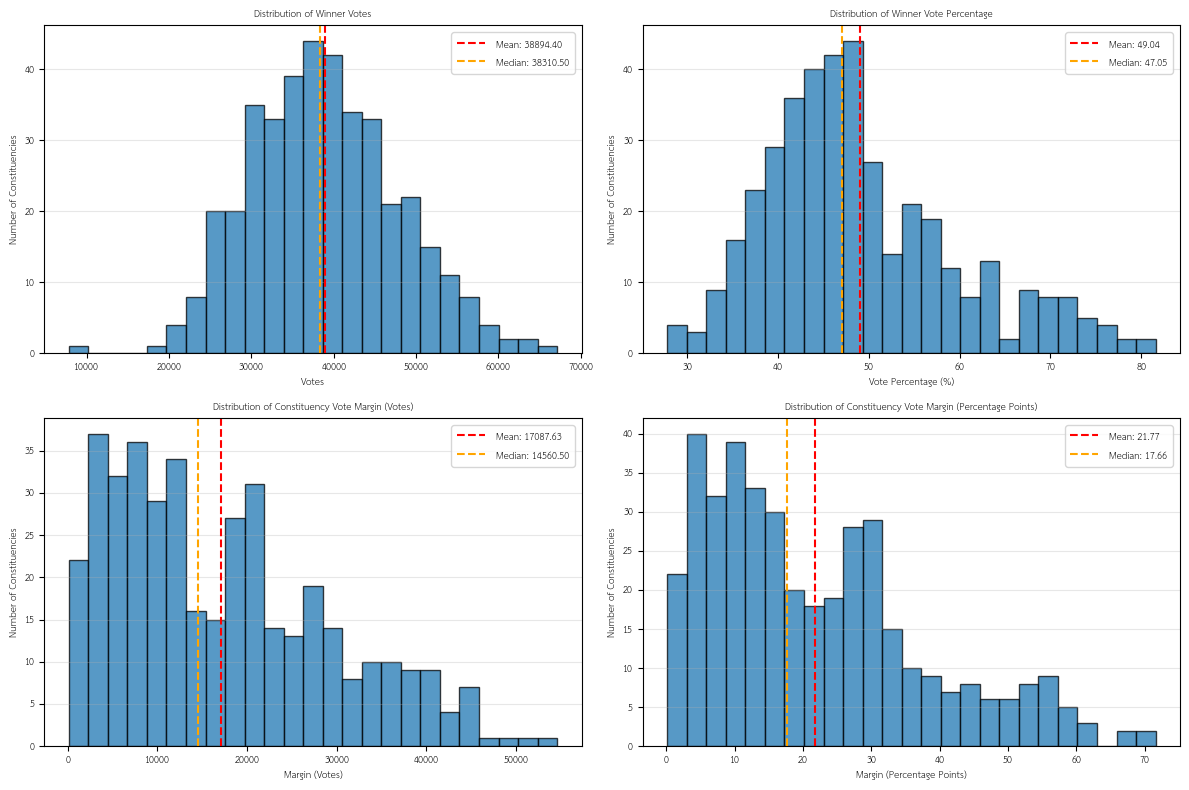

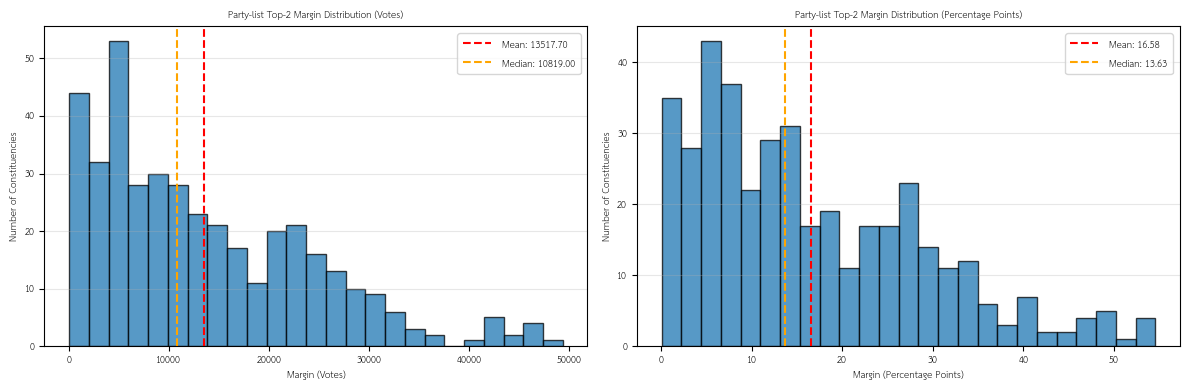

In [33]:
distribution_columns = [
    "winner_votes",
    "winner_percent",
    "vote_margin_votes",
    "vote_margin_pct_points",
]

distribution_summary = (
    winner_profile[distribution_columns]
    .apply(pd.to_numeric, errors="coerce")
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    .T
)
distribution_summary

title_map = {
    "winner_votes": "Distribution of Winner Votes",
    "winner_percent": "Distribution of Winner Vote Percentage",
    "vote_margin_votes": "Distribution of Constituency Vote Margin (Votes)",
    "vote_margin_pct_points": "Distribution of Constituency Vote Margin (Percentage Points)",
}
xlabel_map = {
    "winner_votes": "Votes",
    "winner_percent": "Vote Percentage (%)",
    "vote_margin_votes": "Margin (Votes)",
    "vote_margin_pct_points": "Margin (Percentage Points)",
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for idx, column in enumerate(distribution_columns):
    ax = axes[idx // 2, idx % 2]
    series = pd.to_numeric(winner_profile[column], errors="coerce").dropna()
    ax.hist(series, bins=25, alpha=0.75, edgecolor="black")
    ax.axvline(
        series.mean(),
        color="red",
        linestyle="--",
        linewidth=1.5,
        label=f"Mean: {series.mean():.2f}",
    )
    ax.axvline(
        series.median(),
        color="orange",
        linestyle="--",
        linewidth=1.5,
        label=f"Median: {series.median():.2f}",
    )
    ax.set_title(title_map[column], fontproperties=thai_font)
    ax.set_xlabel(xlabel_map[column], fontproperties=thai_font)
    ax.set_ylabel("Number of Constituencies", fontproperties=thai_font)
    ax.grid(axis="y", alpha=0.3)
    ax.legend(prop=thai_font)

plt.tight_layout()
plt.show()

partylist_margin_numeric = partylist_margin_profile[
    ["partylist_margin_votes", "partylist_margin_pct_points"]
].apply(pd.to_numeric, errors="coerce")

partylist_margin_summary = partylist_margin_numeric.describe(
    percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
).T
partylist_margin_summary["mean"] = partylist_margin_numeric.mean()
partylist_margin_summary["median"] = partylist_margin_numeric.median()
partylist_margin_summary["std"] = partylist_margin_numeric.std()
partylist_margin_summary["iqr"] = partylist_margin_summary["75%"] - partylist_margin_summary["25%"]
partylist_margin_summary = partylist_margin_summary[
    [
        "count",
        "mean",
        "median",
        "std",
        "min",
        "10%",
        "25%",
        "50%",
        "75%",
        "90%",
        "max",
        "iqr",
    ]
]
partylist_margin_summary

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
margin_plot_columns = ["partylist_margin_votes", "partylist_margin_pct_points"]
margin_title_map = {
    "partylist_margin_votes": "Party-list Top-2 Margin Distribution (Votes)",
    "partylist_margin_pct_points": "Party-list Top-2 Margin Distribution (Percentage Points)",
}
margin_xlabel_map = {
    "partylist_margin_votes": "Margin (Votes)",
    "partylist_margin_pct_points": "Margin (Percentage Points)",
}

for idx, column in enumerate(margin_plot_columns):
    ax = axes[idx]
    series = partylist_margin_numeric[column].dropna()
    ax.hist(series, bins=25, alpha=0.75, edgecolor="black")
    ax.axvline(
        series.mean(),
        color="red",
        linestyle="--",
        linewidth=1.5,
        label=f"Mean: {series.mean():.2f}",
    )
    ax.axvline(
        series.median(),
        color="orange",
        linestyle="--",
        linewidth=1.5,
        label=f"Median: {series.median():.2f}",
    )
    ax.set_title(margin_title_map[column], fontproperties=thai_font)
    ax.set_xlabel(margin_xlabel_map[column], fontproperties=thai_font)
    ax.set_ylabel("Number of Constituencies", fontproperties=thai_font)
    ax.grid(axis="y", alpha=0.3)
    ax.legend(prop=thai_font)

plt.tight_layout()
plt.show()

### Party vote and seat shares

In [34]:
party_profile = party_frame.copy()
for column in [
    "totalSeats",
    "constituencySeats",
    "partyListSeats",
    "totalConstituencyVotes",
    "totalPartyListVotes",
]:
    party_profile[column] = pd.to_numeric(party_profile[column], errors="coerce")

party_profile["combinedVotes"] = (
    party_profile["totalConstituencyVotes"] + party_profile["totalPartyListVotes"]
)
party_profile["seat_share_pct"] = (
    party_profile["totalSeats"] / party_profile["totalSeats"].sum() * 100
)
party_profile["vote_share_const_pct"] = (
    party_profile["totalConstituencyVotes"] / party_profile["totalConstituencyVotes"].sum() * 100
)
party_profile["vote_share_partylist_pct"] = (
    party_profile["totalPartyListVotes"] / party_profile["totalPartyListVotes"].sum() * 100
)
party_profile["vote_share_combined_pct"] = (
    party_profile["combinedVotes"] / party_profile["combinedVotes"].sum() * 100
)

top_by_seats = party_profile.sort_values("totalSeats", ascending=False).head(10)[
    ["partyName", "totalSeats", "seat_share_pct"]
]
top_by_const_votes = party_profile.sort_values("totalConstituencyVotes", ascending=False).head(10)[
    ["partyName", "totalConstituencyVotes", "vote_share_const_pct"]
]
top_by_partylist_votes = party_profile.sort_values("totalPartyListVotes", ascending=False).head(10)[
    ["partyName", "totalPartyListVotes", "vote_share_partylist_pct"]
]
top_by_combined_votes = party_profile.sort_values("combinedVotes", ascending=False).head(10)[
    ["partyName", "combinedVotes", "vote_share_combined_pct"]
]

top_by_seats

,partyName,totalSeats,seat_share_pct
0,พรรคภูมิใจไทย,193,38.6
1,พรรคประชาชน,118,23.6
2,พรรคเพื่อไทย,74,14.8
3,พรรคกล้าธรรม,58,11.6
4,พรรคประชาธิปัตย์,22,4.4
5,พรรคไทรวมพลัง,6,1.2
6,พรรคประชาชาติ,5,1.0
7,พรรคพลังประชารัฐ,5,1.0
8,พรรคเศรษฐกิจ,3,0.6
9,พรรคไทยสร้างไทย,2,0.4


### Seat composition and vote-seat relationship

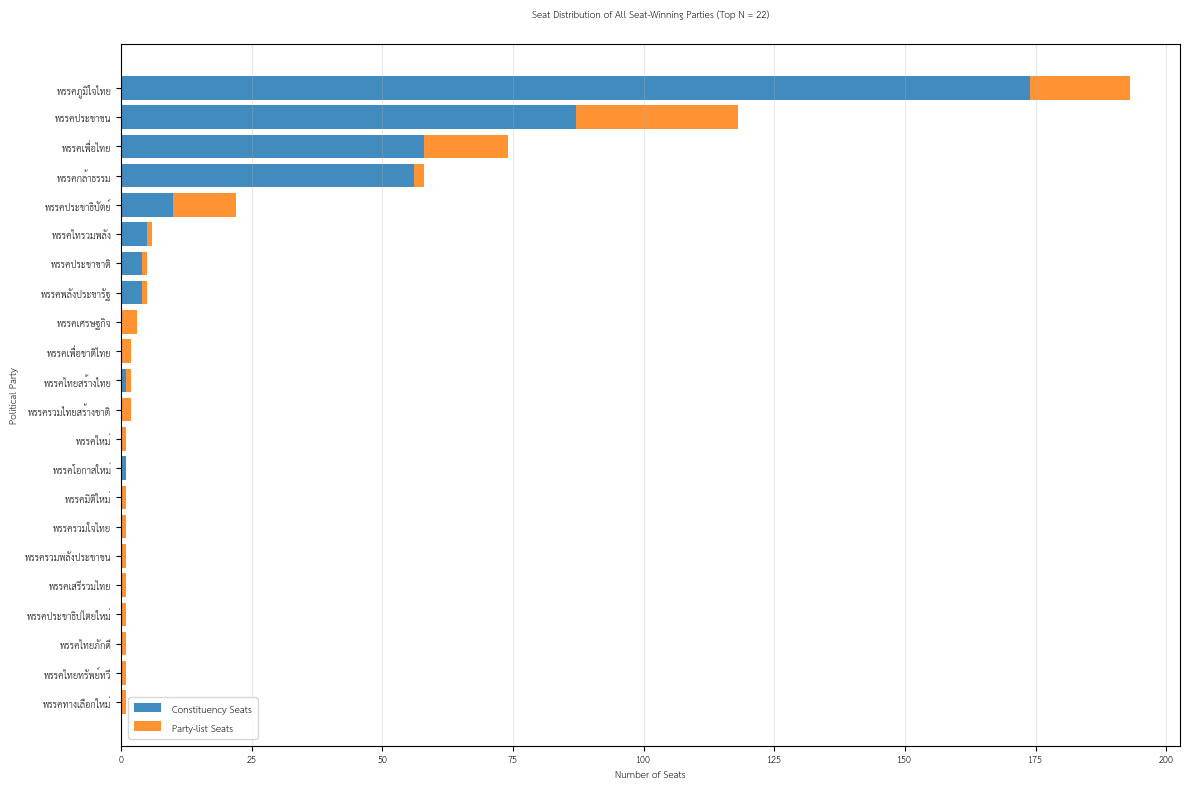

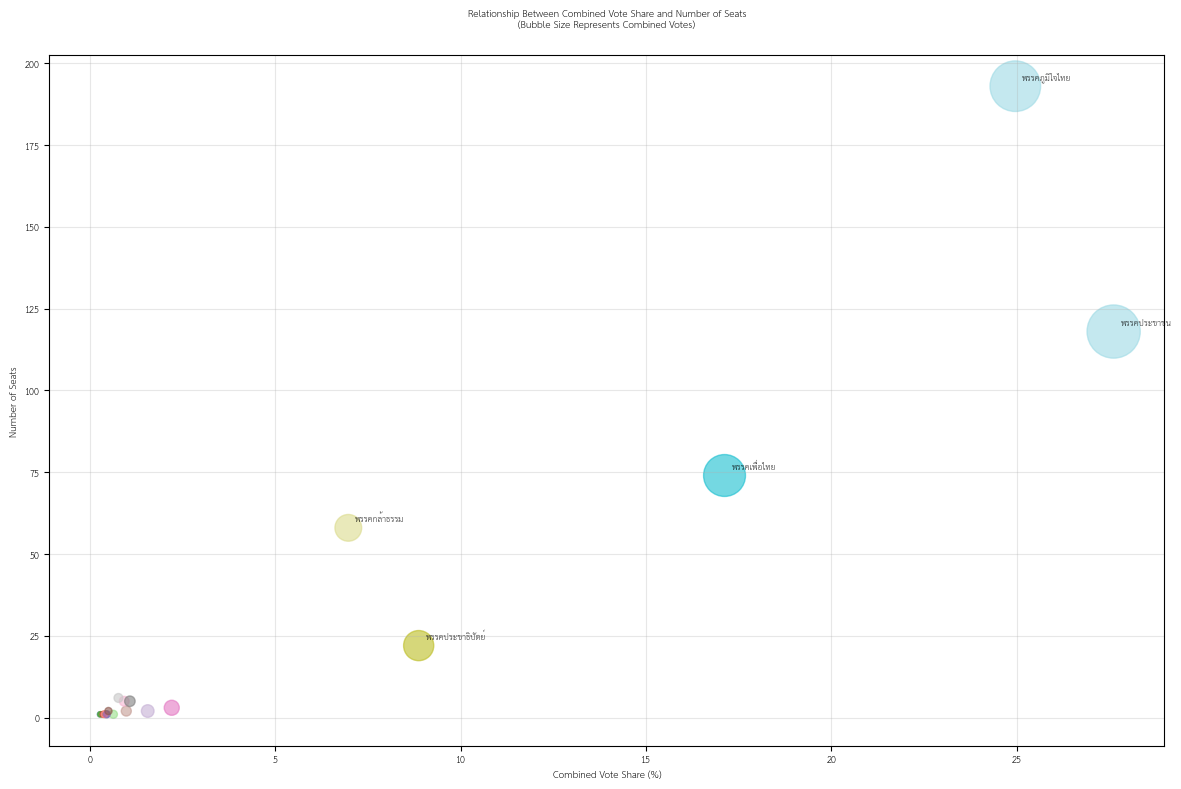

,partyName,combinedVotes,totalSeats,votes_per_seat,vote_share_combined_pct
3,พรรคกล้าธรรม,4449389,58,76713.603448,6.973772
5,พรรคไทรวมพลัง,493742,6,82290.333333,0.773869
0,พรรคภูมิใจไทย,15927763,193,82527.269430,24.964458
7,พรรคพลังประชารัฐ,592925,5,118585.000000,0.929324
6,พรรคประชาชาติ,690286,5,138057.200000,1.081923
2,พรรคเพื่อไทย,10923700,74,147617.567568,17.121315
1,พรรคประชาชน,17619788,118,149320.237288,27.616462
9,พรรคไทยสร้างไทย,321718,2,160859.000000,0.504246
12,พรรคทางเลือกใหม่,175625,1,175625.000000,0.275267
18,พรรครวมพลังประชาชน,183956,1,183956.000000,0.288324


In [35]:
party_with_seats = party_profile[party_profile["totalSeats"] > 0].copy()
party_with_seats = party_with_seats.sort_values("totalSeats", ascending=True)
top_n_seat_winning = len(party_with_seats)

plt.figure(figsize=(12, 8))
plt.barh(
    party_with_seats["partyName"],
    party_with_seats["constituencySeats"],
    label="Constituency Seats",
    alpha=0.85,
)
plt.barh(
    party_with_seats["partyName"],
    party_with_seats["partyListSeats"],
    left=party_with_seats["constituencySeats"],
    label="Party-list Seats",
    alpha=0.85,
)
plt.xlabel("Number of Seats", fontproperties=thai_font)
plt.ylabel("Political Party", fontproperties=thai_font)
plt.title(
    f"Seat Distribution of All Seat-Winning Parties (Top N = {top_n_seat_winning})",
    fontproperties=thai_font,
    pad=20,
)
plt.legend(prop=thai_font)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(
    party_with_seats["vote_share_combined_pct"],
    party_with_seats["totalSeats"],
    s=party_with_seats["combinedVotes"] / 12000,
    alpha=0.6,
    c=range(len(party_with_seats)),
    cmap="tab20",
)

for _, row in party_with_seats.iterrows():
    if row["totalSeats"] >= 10:
        plt.annotate(
            row["partyName"],
            (row["vote_share_combined_pct"], row["totalSeats"]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=9,
            fontproperties=thai_font,
            alpha=0.85,
        )

plt.xlabel("Combined Vote Share (%)", fontproperties=thai_font)
plt.ylabel("Number of Seats", fontproperties=thai_font)
plt.title(
    "Relationship Between Combined Vote Share and Number of Seats\n(Bubble Size Represents Combined Votes)",
    fontproperties=thai_font,
    pad=20,
)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

party_with_seats["votes_per_seat"] = (
    party_with_seats["combinedVotes"] / party_with_seats["totalSeats"]
).replace([float("inf")], pd.NA)

seat_vote_relationship_table = party_with_seats[
    [
        "partyName",
        "combinedVotes",
        "totalSeats",
        "votes_per_seat",
        "vote_share_combined_pct",
    ]
].sort_values("votes_per_seat")
seat_vote_relationship_table.head(15)

### Top-party summary table

In [36]:
top_parties_summary = pd.concat(
    [
        top_by_seats.reset_index(drop=True),
        top_by_const_votes.reset_index(drop=True),
        top_by_partylist_votes.reset_index(drop=True),
        top_by_combined_votes.reset_index(drop=True),
    ],
    axis=1,
    keys=["By seats", "By constituency votes", "By party-list votes", "By combined votes"],
)

top_parties_summary

By seats                           By constituency votes  \
          partyName totalSeats seat_share_pct             partyName   
0     พรรคภูมิใจไทย        193           38.6         พรรคภูมิใจไทย   
1       พรรคประชาชน        118           23.6           พรรคประชาชน   
2      พรรคเพื่อไทย         74           14.8          พรรคเพื่อไทย   
3      พรรคกล้าธรรม         58           11.6          พรรคกล้าธรรม   
4  พรรคประชาธิปัตย์         22            4.4      พรรคประชาธิปัตย์   
5     พรรคไทรวมพลัง          6            1.2      พรรคพลังประชารัฐ   
6     พรรคประชาชาติ          5            1.0          พรรคเศรษฐกิจ   
7  พรรคพลังประชารัฐ          5            1.0         พรรคไทรวมพลัง   
8      พรรคเศรษฐกิจ          3            0.6   พรรครวมไทยสร้างชาติ   
9   พรรคไทยสร้างไทย          2            0.4         พรรคประชาชาติ   

                                               By party-list votes  \
  totalConstituencyVotes vote_share_const_pct            partyName   
0                9973228            31.289433          พรรคประชาชน   
1                7841837            24.602529        พรรคภูมิใจไทย   
2                5776100            18.121605         พรรคเพื่อไทย   
3                3843453            12.058229     พรรคประชาธิปัตย์   
4                2009435             6.304286         พรรคเศรษฐกิจ   
5                 462974             1.452508  พรรครวมไทยสร้างชาติ   
6                 365434             1.146492     พรรคเพื่อชาติไทย   
7                 341328             1.070863         พรรคกล้าธรรม   
8                 292480             0.917610         พรรครวมใจไทย   
9                 288759             0.905936        พรรคประชาชาติ   

                                                  By combined votes  \
  totalPartyListVotes vote_share_partylist_pct            partyName   
0             9777951                30.625341          พรรคประชาชน   
1             5954535                18.650090        พรรคภูมิใจไทย   
2             5147600                16.122703         พรรคเพื่อไทย   
3             3651026                11.435311     พรรคประชาธิปัตย์   
4             1045452                 3.274441         พรรคกล้าธรรม   
5              705035                 2.208227         พรรคเศรษฐกิจ   
6              628493                 1.968491  พรรครวมไทยสร้างชาติ   
7              605936                 1.897841        พรรคประชาชาติ   
8              403671                 1.264331     พรรคเพื่อชาติไทย   
9              401527                 1.257615     พรรคพลังประชารัฐ   

                                         
  combinedVotes vote_share_combined_pct  
0      17619788               27.616462  
1      15927763               24.964458  
2      10923700               17.121315  
3       5660461                8.871952  
4       4449389                6.973772  
5       1410886                2.211359  
6        997515                1.563460  
7        690286                1.081923  
8        628952                0.985791  
9        592925                0.929324

### Representation gap table

In [37]:
representation_gap = party_profile[
    [
        "partyName",
        "totalSeats",
        "combinedVotes",
        "seat_share_pct",
        "vote_share_combined_pct",
        "vote_share_const_pct",
        "vote_share_partylist_pct",
    ]
].copy()

representation_gap["gap_vs_combined_vote_pct_points"] = (
    representation_gap["seat_share_pct"] - representation_gap["vote_share_combined_pct"]
)
representation_gap["gap_vs_const_vote_pct_points"] = (
    representation_gap["seat_share_pct"] - representation_gap["vote_share_const_pct"]
)
representation_gap["gap_vs_partylist_vote_pct_points"] = (
    representation_gap["seat_share_pct"] - representation_gap["vote_share_partylist_pct"]
)

over_represented = representation_gap.sort_values(
    "gap_vs_combined_vote_pct_points", ascending=False
).head(10)[
    [
        "partyName",
        "seat_share_pct",
        "vote_share_combined_pct",
        "gap_vs_combined_vote_pct_points",
    ]
]

under_represented = representation_gap.sort_values(
    "gap_vs_combined_vote_pct_points", ascending=True
).head(10)[
    [
        "partyName",
        "seat_share_pct",
        "vote_share_combined_pct",
        "gap_vs_combined_vote_pct_points",
    ]
]

over_represented, under_represented

(             partyName  seat_share_pct  vote_share_combined_pct  \
 0        พรรคภูมิใจไทย            38.6                24.964458   
 3         พรรคกล้าธรรม            11.6                 6.973772   
 5        พรรคไทรวมพลัง             1.2                 0.773869   
 7     พรรคพลังประชารัฐ             1.0                 0.929324   
 58     พรรคสัมมาธิปไตย             0.0                 0.000000   
 51         พรรครวมพลัง             0.0                 0.000000   
 53       พรรครักษ์ธรรม             0.0                 0.000000   
 38   พรรคประชาอาสาชาติ             0.0                 0.008520   
 34  พรรคไทยพิทักษ์ธรรม             0.0                 0.010409   
 35       พรรคไทยรวมไทย             0.0                 0.011986   
 
     gap_vs_combined_vote_pct_points  
 0                         13.635542  
 3                          4.626228  
 5                          0.426131  
 7                          0.070676  
 58                         0.000000  
 51             

### Snapshot metrics for insights

In [38]:
insight_snapshot = {
    "total_seats": int(seat_total_from_rows),
    "constituency_seats": int(constituency_seats),
    "party_list_seats": int(party_list_seats),
    "constituency_votes_total": int(constituency_votes_total),
    "party_list_votes_total": int(party_list_votes_total),
    "combined_votes_total": int(combined_votes_total),
    "winner_constituency_ballots_total": int(winner_constituency_votes_total),
    "referendum_total_votes": int(referendum_total_votes),
    "winner_votes_median": float(winner_profile["winner_votes"].median()),
    "winner_percent_median": float(winner_profile["winner_percent"].median()),
    "vote_margin_votes_median": float(winner_profile["vote_margin_votes"].median()),
    "vote_margin_pct_points_median": float(winner_profile["vote_margin_pct_points"].median()),
    "partylist_margin_pct_points_median": float(
        partylist_margin_profile["partylist_margin_pct_points"].median()
    ),
}

leaders_snapshot = {
    "top_seat_party": top_by_seats.iloc[0]["partyName"],
    "top_seat_count": int(top_by_seats.iloc[0]["totalSeats"]),
    "top_const_vote_party": top_by_const_votes.iloc[0]["partyName"],
    "top_const_vote_count": int(top_by_const_votes.iloc[0]["totalConstituencyVotes"]),
    "top_partylist_vote_party": top_by_partylist_votes.iloc[0]["partyName"],
    "top_partylist_vote_count": int(top_by_partylist_votes.iloc[0]["totalPartyListVotes"]),
    "top_combined_vote_party": top_by_combined_votes.iloc[0]["partyName"],
    "top_combined_vote_count": int(top_by_combined_votes.iloc[0]["combinedVotes"]),
    "most_over_repr_party": over_represented.iloc[0]["partyName"],
    "most_over_repr_gap": float(over_represented.iloc[0]["gap_vs_combined_vote_pct_points"]),
    "most_under_repr_party": under_represented.iloc[0]["partyName"],
    "most_under_repr_gap": float(under_represented.iloc[0]["gap_vs_combined_vote_pct_points"]),
}

insight_snapshot, leaders_snapshot

({'total_seats': 500,
  'constituency_seats': 400,
  'party_list_seats': 100,
  'constituency_votes_total': 31874109,
  'party_list_votes_total': 31927648,
  'combined_votes_total': 63801757,
  'winner_constituency_ballots_total': 28602136,
  'referendum_total_votes': 33354794,
  'winner_votes_median': 38310.5,
  'winner_percent_median': 47.05,
  'vote_margin_votes_median': 14560.5,
  'vote_margin_pct_points_median': 17.655,
  'partylist_margin_pct_points_median': 13.630443763196435},
 {'top_seat_party': 'พรรคภูมิใจไทย',
  'top_seat_count': 193,
  'top_const_vote_party': 'พรรคภูมิใจไทย',
  'top_const_vote_count': 9973228,
  'top_partylist_vote_party': 'พรรคประชาชน',
  'top_partylist_vote_count': 9777951,
  'top_combined_vote_party': 'พรรคประชาชน',
  'top_combined_vote_count': 17619788,
  'most_over_repr_party': 'พรรคภูมิใจไทย',
  'most_over_repr_gap': 13.635541732808392,
  'most_under_repr_party': 'พรรคประชาธิปัตย์',
  'most_under_repr_gap': -4.4719515984489275})

### Insights

- We have 500 total seats: 400 constituency seats and 100 party-list seats.
- Total constituency votes are 31,874,109 and total party-list votes are 31,927,648, so combined votes are 63,801,757.
- Turnout-related totals show 28,602,136 constituency ballots from `winner.candidates` and 33,354,794 referendum votes from `map.referendums`.
- The median winner got 38,310.5 votes and 47.05% vote share, which means many winners won with less than half of all votes in their constituency.
- The median constituency margin is 14,560.5 votes (17.655 percentage points), while the median party-list top-2 margin is 13.63 percentage points.
- By seats, the top party is พรรคภูมิใจไทย with 193 seats.
- By constituency votes, the top party is พรรคภูมิใจไทย with 9,973,228 votes.
- By party-list votes, the top party is พรรคประชาชน with 9,777,951 votes.
- By combined votes, the top party is พรรคประชาชน with 17,619,788 votes.
- The biggest over-representation (seat share minus combined vote share) is พรรคภูมิใจไทย at +13.64 points, while the biggest under-representation is พรรคประชาธิปัตย์ at -4.47 points.

# Competitiveness analysis

## Competitiveness framework

In [39]:
def build_competitiveness_base():
    base = winner_profile[
        ["id", "provinceName", "vote_margin_votes", "vote_margin_pct_points"]
    ].copy()
    base["vote_margin_votes"] = pd.to_numeric(base["vote_margin_votes"], errors="coerce")
    base["vote_margin_pct_points"] = pd.to_numeric(base["vote_margin_pct_points"], errors="coerce")
    base = base.dropna(subset=["vote_margin_pct_points"]).copy()

    winner_lookup_columns = ["id"]
    for column in ["number", "areaNumber", "constituencyName"]:
        if column in dfs["winner"].columns:
            winner_lookup_columns.append(column)

    winner_lookup = dfs["winner"][winner_lookup_columns].copy()
    base = base.merge(winner_lookup, on="id", how="left")
    return base


def classify_competitiveness(margin_pct):
    if margin_pct < 5:
        return "Highly competitive (<5)"
    if margin_pct < 10:
        return "Competitive (5-<10)"
    if margin_pct < 20:
        return "Moderate (10-<20)"
    return "Safe (>=20)"


class_order = [
    "Highly competitive (<5)",
    "Competitive (5-<10)",
    "Moderate (10-<20)",
    "Safe (>=20)",
]

## Competitiveness class distribution table

In [40]:
competitiveness_base = build_competitiveness_base()
competitiveness_base["competitiveness_class"] = competitiveness_base[
    "vote_margin_pct_points"
].apply(classify_competitiveness)
competitiveness_base["competitiveness_class"] = pd.Categorical(
    competitiveness_base["competitiveness_class"], categories=class_order, ordered=True
)

class_distribution = (
    competitiveness_base["competitiveness_class"]
    .value_counts(dropna=False)
    .reindex(class_order, fill_value=0)
    .rename_axis("competitiveness_class")
    .reset_index(name="constituencies")
)
class_distribution["share_pct"] = (
    class_distribution["constituencies"] / class_distribution["constituencies"].sum() * 100
).round(2)

class_distribution

,competitiveness_class,constituencies,share_pct
0,Highly competitive (<5),54,13.50
1,Competitive (5-<10),60,15.00
2,Moderate (10-<20),101,25.25
3,Safe (>=20),185,46.25


## Competitiveness class distribution chart

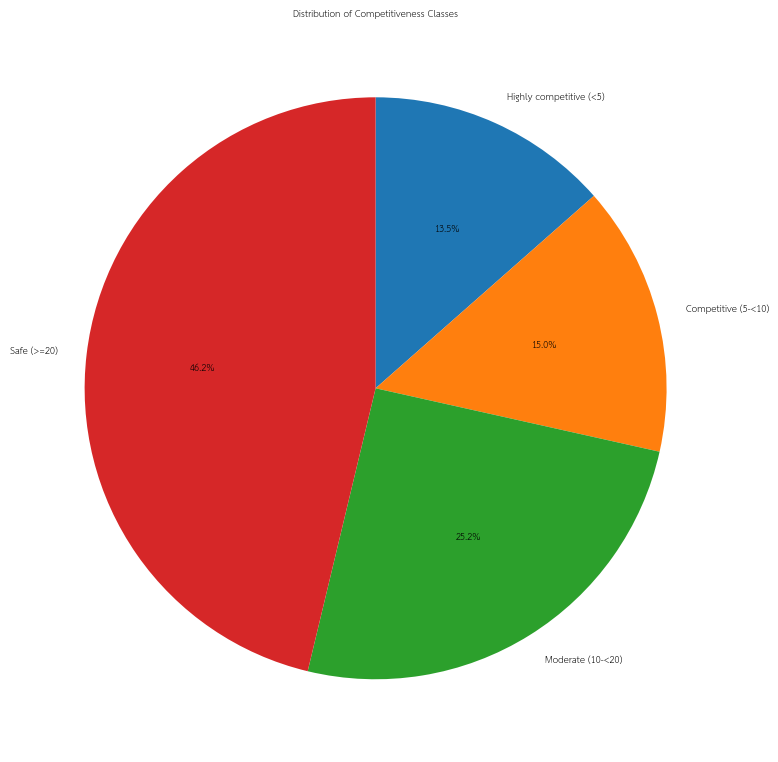

In [41]:
competitiveness_base = build_competitiveness_base()
competitiveness_base["competitiveness_class"] = competitiveness_base[
    "vote_margin_pct_points"
].apply(classify_competitiveness)
competitiveness_base["competitiveness_class"] = pd.Categorical(
    competitiveness_base["competitiveness_class"], categories=class_order, ordered=True
)

class_distribution = (
    competitiveness_base["competitiveness_class"]
    .value_counts(dropna=False)
    .reindex(class_order, fill_value=0)
    .rename_axis("competitiveness_class")
    .reset_index(name="constituencies")
)

plt.figure(figsize=(8, 8))
plt.pie(
    class_distribution["constituencies"],
    labels=class_distribution["competitiveness_class"],
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
)
plt.title("Distribution of Competitiveness Classes", fontproperties=thai_font)
plt.tight_layout()
plt.show()

## Closest races

In [42]:
competitiveness_base = build_competitiveness_base()
competitiveness_base["competitiveness_class"] = competitiveness_base[
    "vote_margin_pct_points"
].apply(classify_competitiveness)

race_columns = ["id", "provinceName"]
for column in ["number", "areaNumber", "constituencyName"]:
    if column in competitiveness_base.columns:
        race_columns.append(column)
race_columns.extend(["vote_margin_votes", "vote_margin_pct_points", "competitiveness_class"])

closest_races = competitiveness_base.sort_values("vote_margin_pct_points", ascending=True).head(10)[
    race_columns
]
closest_races

,id,provinceName,number,vote_margin_votes,vote_margin_pct_points,competitiveness_class
397,88885a3d-1f44-438a-8219-0b4c0f2abaf3,นราธิวาส,3,113.0,0.14,Highly competitive (<5)
145,5c131e8f-ae43-4d1e-8e8b-22f24a5359a3,ศรีสะเกษ,6,216.0,0.32,Highly competitive (<5)
275,183a5607-03e3-492d-83c0-7975e8762968,แม่ฮ่องสอน,2,287.0,0.45,Highly competitive (<5)
108,a14de92a-594b-4f43-8fa1-8c81420a8cbe,นครราชสีมา,3,530.0,0.61,Highly competitive (<5)
180,aafb27ff-4787-4e42-ba60-3a6b81ee6532,ขอนแก่น,3,611.0,0.79,Highly competitive (<5)
195,e230711a-bf99-4230-a4c4-dfd7f139530b,อุดรธานี,7,516.0,0.83,Highly competitive (<5)
215,bef35884-c43a-4645-8c94-ca653f70eb90,ร้อยเอ็ด,4,679.0,0.88,Highly competitive (<5)
71,8e589596-9e6c-40ce-89f9-fff854591eab,สระบุรี,1,850.0,1.04,Highly competitive (<5)
295,2055049c-e8be-4649-8888-a10b27399391,พิษณุโลก,1,888.0,1.05,Highly competitive (<5)
329,378416c4-e0ce-4ef7-b2e9-b56ce8166a64,นครปฐม,6,895.0,1.06,Highly competitive (<5)


## Safest races

In [43]:
competitiveness_base = build_competitiveness_base()
competitiveness_base["competitiveness_class"] = competitiveness_base[
    "vote_margin_pct_points"
].apply(classify_competitiveness)

race_columns = ["id", "provinceName"]
for column in ["number", "areaNumber", "constituencyName"]:
    if column in competitiveness_base.columns:
        race_columns.append(column)
race_columns.extend(["vote_margin_votes", "vote_margin_pct_points", "competitiveness_class"])

safest_races = competitiveness_base.sort_values("vote_margin_pct_points", ascending=False).head(10)[
    race_columns
]
safest_races

,id,provinceName,number,vote_margin_votes,vote_margin_pct_points,competitiveness_class
130,e049be80-65c4-43c1-ad65-652b0ed25177,บุรีรัมย์,9,44408.0,71.61,Safe (>=20)
124,ae05d898-1f46-4d82-8d4e-aa266a3551f9,บุรีรัมย์,3,44523.0,69.97,Safe (>=20)
131,219c59a4-6a87-44cb-aae1-a1fbc3bc2b02,บุรีรัมย์,10,41527.0,68.61,Safe (>=20)
158,a33be955-f6c4-47ae-9a55-cd4afe07d5b5,อุบลราชธานี,10,52359.0,67.91,Safe (>=20)
147,155bfdce-709e-438b-ba1c-d7e26ec3053f,ศรีสะเกษ,8,44432.0,61.83,Safe (>=20)
337,f4a4d77f-1abf-478f-8d5f-73f4563b9a73,เพชรบุรี,3,54615.0,61.60,Safe (>=20)
264,b8e51dc9-999a-4ee0-a967-5b0c2be092c2,พะเยา,1,48578.0,61.15,Safe (>=20)
127,cdaeee2b-1f46-43ad-95fa-5a706e9dbadc,บุรีรัมย์,6,38638.0,60.08,Safe (>=20)
122,aae90b72-fb34-43dc-adac-13b00541a1a4,บุรีรัมย์,1,41799.0,59.33,Safe (>=20)
63,ca4a85d3-c43d-45d2-93e3-bd97f831fbfa,อ่างทอง,2,44122.0,58.27,Safe (>=20)


## Small-margin threshold summary

In [44]:
competitiveness_base = build_competitiveness_base()

valid_n = len(competitiveness_base)
small_margin_summary = pd.DataFrame(
    [
        {
            "threshold": "<5 pct points",
            "constituencies": int((competitiveness_base["vote_margin_pct_points"] < 5).sum()),
            "denominator_valid_constituencies": int(valid_n),
        },
        {
            "threshold": "<10 pct points",
            "constituencies": int((competitiveness_base["vote_margin_pct_points"] < 10).sum()),
            "denominator_valid_constituencies": int(valid_n),
        },
    ]
)
small_margin_summary["share_pct"] = (
    small_margin_summary["constituencies"]
    / small_margin_summary["denominator_valid_constituencies"]
    * 100
).round(2)

small_margin_summary

,threshold,constituencies,denominator_valid_constituencies,share_pct
0,<5 pct points,54,400,13.5
1,<10 pct points,114,400,28.5


## Province-level margin summary

In [45]:
competitiveness_base = build_competitiveness_base()

province_margin_summary = (
    competitiveness_base.groupby("provinceName", dropna=False)["vote_margin_pct_points"]
    .agg(
        constituencies="count",
        avg_margin_pct_points="mean",
        variance_margin_pct_points="var",
        std_margin_pct_points="std",
    )
    .reset_index()
    .sort_values("avg_margin_pct_points", ascending=True)
)

province_margin_summary

,provinceName,constituencies,avg_margin_pct_points,variance_margin_pct_points,std_margin_pct_points
36,ภูเก็ต,3,7.290000,34.809600,5.899966
6,จันทบุรี,3,7.390000,30.410800,5.514599
15,นครนายก,2,8.160000,1.411200,1.187939
23,น่าน,3,8.450000,1.775100,1.332329
59,สุราษฎร์ธานี,7,9.505714,42.800462,6.542206
...,...,...,...,...,...
69,อ่างทอง,2,52.980000,55.968200,7.481190
41,ระนอง,1,53.920000,NaN,NaN
72,เพชรบุรี,3,54.616667,38.605833,6.213359
67,อุทัยธานี,2,56.425000,0.781250,0.883883


### Insights

- Most constituencies are in the Safe class (46.25%), so many races were not close.
- Close races still matter: 13.5% of constituencies were decided by less than 5 percentage points.
- If we use a wider cutoff, 28.5% were decided by less than 10 percentage points.
- The closest race had a margin of 0.14 percentage points, while the safest race had 71.61 percentage points.
- Province patterns are different: average margins are low in some provinces (for example, Phuket at about 7.29) but very high in others (for example, Buriram at about 58.96).

# Geographic analysis

## Province and regional winner extraction

In [46]:
def extract_winning_party_name(candidates_raw):
    records = to_records(candidates_raw)
    best_party = "Unknown"
    best_rank = float("inf")
    best_votes = float("-inf")

    for item in records:
        if not isinstance(item, dict):
            continue

        rank = pd.to_numeric(item.get("rank"), errors="coerce")
        votes = pd.to_numeric(item.get("totalVotes"), errors="coerce")
        party = item.get("party") if isinstance(item.get("party"), dict) else {}
        party_name = str(party.get("name", "Unknown")).strip() or "Unknown"

        candidate_rank = rank if pd.notna(rank) else float("inf")
        candidate_votes = votes if pd.notna(votes) else float("-inf")

        if candidate_rank < best_rank or (
            candidate_rank == best_rank and candidate_votes > best_votes
        ):
            best_rank = candidate_rank
            best_votes = candidate_votes
            best_party = party_name

    return best_party


winner_geo = dfs["winner"][["id", "provinceId", "provinceName", "candidates"]].copy()
winner_geo["winningParty"] = winner_geo["candidates"].apply(extract_winning_party_name)

province_winner_base = winner_geo[["id", "provinceId", "provinceName", "winningParty"]].copy()

province_party_wins = (
    province_winner_base.groupby(["provinceName", "winningParty"], dropna=False)
    .size()
    .reset_index(name="wins")
)

province_totals = (
    province_winner_base.groupby("provinceName", dropna=False)
    .size()
    .reset_index(name="total_constituencies")
)

province_unique_parties = (
    province_party_wins.groupby("provinceName", dropna=False)["winningParty"]
    .nunique()
    .reset_index(name="unique_winning_parties")
)

province_top_party = (
    province_party_wins.sort_values(["provinceName", "wins"], ascending=[True, False])
    .drop_duplicates(subset=["provinceName"], keep="first")
    .rename(columns={"winningParty": "top_party", "wins": "top_party_wins"})
)

province_competitiveness = province_unique_parties.merge(
    province_totals, on="provinceName", how="left"
).merge(
    province_top_party[["provinceName", "top_party", "top_party_wins"]],
    on="provinceName",
    how="left",
)
province_competitiveness["top_party_share_pct"] = (
    province_competitiveness["top_party_wins"]
    / province_competitiveness["total_constituencies"]
    * 100
).round(2)
province_competitiveness["province_type"] = province_competitiveness[
    "unique_winning_parties"
].apply(lambda x: "Dominated by one party" if x == 1 else "Competitive multi-party")

province_competitiveness = province_competitiveness.sort_values(
    ["unique_winning_parties", "top_party_share_pct", "provinceName"],
    ascending=[False, False, True],
)

province_type_distribution = (
    province_competitiveness["province_type"]
    .value_counts()
    .rename_axis("province_type")
    .reset_index(name="provinces")
)
province_type_distribution["share_pct"] = (
    province_type_distribution["provinces"] / province_type_distribution["provinces"].sum() * 100
).round(2)

unique_party_ranking = province_competitiveness[
    ["provinceName", "unique_winning_parties", "province_type", "top_party", "top_party_share_pct"]
].sort_values(["unique_winning_parties", "top_party_share_pct"], ascending=[False, True])

region_by_province_id = {
    10: "Bangkok",
    11: "Central",
    12: "Central",
    13: "Central",
    14: "Central",
    15: "Central",
    16: "Central",
    17: "Central",
    18: "Central",
    19: "Central",
    20: "East",
    21: "East",
    22: "East",
    23: "East",
    24: "East",
    25: "East",
    26: "East",
    27: "East",
    30: "Northeast",
    31: "Northeast",
    32: "Northeast",
    33: "Northeast",
    34: "Northeast",
    35: "Northeast",
    36: "Northeast",
    37: "Northeast",
    38: "Northeast",
    39: "Northeast",
    40: "Northeast",
    41: "Northeast",
    42: "Northeast",
    43: "Northeast",
    44: "Northeast",
    45: "Northeast",
    46: "Northeast",
    47: "Northeast",
    48: "Northeast",
    49: "Northeast",
    50: "North",
    51: "North",
    52: "North",
    53: "North",
    54: "North",
    55: "North",
    56: "North",
    57: "North",
    58: "North",
    60: "North",
    61: "North",
    62: "North",
    63: "North",
    64: "North",
    65: "North",
    66: "North",
    67: "North",
    70: "West",
    71: "West",
    72: "West",
    73: "West",
    74: "West",
    75: "West",
    76: "West",
    77: "West",
    80: "South",
    81: "South",
    82: "South",
    83: "South",
    84: "South",
    85: "South",
    86: "South",
    90: "South",
    91: "South",
    92: "South",
    93: "South",
    94: "South",
    95: "South",
    96: "South",
}

province_winner_base["provinceId"] = pd.to_numeric(
    province_winner_base["provinceId"], errors="coerce"
)
province_winner_base["region"] = (
    province_winner_base["provinceId"].map(region_by_province_id).fillna("Unknown")
)

regional_party_wins = (
    province_winner_base.groupby(["region", "winningParty"], dropna=False)
    .size()
    .reset_index(name="wins")
)

regional_totals = (
    regional_party_wins.groupby("region", dropna=False)["wins"]
    .sum()
    .reset_index(name="region_total_wins")
)

regional_concentration = regional_party_wins.merge(regional_totals, on="region", how="left")
regional_concentration["party_win_share_pct"] = (
    regional_concentration["wins"] / regional_concentration["region_total_wins"] * 100
).round(2)
regional_concentration = regional_concentration.sort_values(
    ["region", "party_win_share_pct"],
    ascending=[True, False],
)

regional_top_party = (
    regional_concentration.sort_values(["region", "wins"], ascending=[True, False])
    .drop_duplicates(subset=["region"], keep="first")[
        ["region", "winningParty", "wins", "party_win_share_pct"]
    ]
    .rename(columns={"winningParty": "top_party"})
)

province_vote_margin_rank = (
    winner_profile.groupby("provinceName", dropna=False)
    .agg(
        total_winner_votes=("winner_votes", "sum"),
        avg_margin_pct_points=("vote_margin_pct_points", "mean"),
    )
    .reset_index()
)

province_vote_margin_rank["total_winner_votes"] = pd.to_numeric(
    province_vote_margin_rank["total_winner_votes"], errors="coerce"
)
province_vote_margin_rank["avg_margin_pct_points"] = pd.to_numeric(
    province_vote_margin_rank["avg_margin_pct_points"], errors="coerce"
)

province_vote_margin_rank["votes_rank"] = province_vote_margin_rank["total_winner_votes"].rank(
    method="dense",
    ascending=False,
)
province_vote_margin_rank["margin_intensity_rank"] = province_vote_margin_rank[
    "avg_margin_pct_points"
].rank(method="dense", ascending=False)
province_vote_margin_rank["composite_rank_score"] = (
    province_vote_margin_rank["votes_rank"] + province_vote_margin_rank["margin_intensity_rank"]
)

province_vote_margin_rank = province_vote_margin_rank.sort_values(
    ["composite_rank_score", "total_winner_votes"],
    ascending=[True, False],
)

## Province competitiveness table

In [47]:
province_party_wins = (
    province_winner_base.groupby(["provinceName", "winningParty"], dropna=False)
    .size()
    .reset_index(name="wins")
)

province_totals = (
    province_winner_base.groupby("provinceName", dropna=False)
    .size()
    .reset_index(name="total_constituencies")
)

province_unique_parties = (
    province_party_wins.groupby("provinceName", dropna=False)["winningParty"]
    .nunique()
    .reset_index(name="unique_winning_parties")
)

province_top_party = (
    province_party_wins.sort_values(["provinceName", "wins"], ascending=[True, False])
    .drop_duplicates(subset=["provinceName"], keep="first")
    .rename(columns={"winningParty": "top_party", "wins": "top_party_wins"})
)

province_competitiveness = province_unique_parties.merge(
    province_totals, on="provinceName", how="left"
).merge(
    province_top_party[["provinceName", "top_party", "top_party_wins"]],
    on="provinceName",
    how="left",
)
province_competitiveness["top_party_share_pct"] = (
    province_competitiveness["top_party_wins"]
    / province_competitiveness["total_constituencies"]
    * 100
).round(2)
province_competitiveness["province_type"] = province_competitiveness[
    "unique_winning_parties"
].apply(lambda x: "Dominated by one party" if x == 1 else "Competitive multi-party")

province_competitiveness = province_competitiveness.sort_values(
    ["unique_winning_parties", "top_party_share_pct", "provinceName"],
    ascending=[False, False, True],
)

province_competitiveness

,provinceName,unique_winning_parties,total_constituencies,top_party,top_party_wins,top_party_share_pct,province_type
44,ร้อยเอ็ด,4,8,พรรคเพื่อไทย,4,50.00,Competitive multi-party
59,สุราษฎร์ธานี,4,7,พรรคภูมิใจไทย,3,42.86,Competitive multi-party
5,ขอนแก่น,4,11,พรรคกล้าธรรม,3,27.27,Competitive multi-party
3,กาฬสินธุ์,3,6,พรรคเพื่อไทย,4,66.67,Competitive multi-party
16,นครปฐม,3,6,พรรคภูมิใจไทย,4,66.67,Competitive multi-party
...,...,...,...,...,...,...,...
64,อำนาจเจริญ,1,2,พรรคภูมิใจไทย,2,100.00,Dominated by one party
67,อุทัยธานี,1,2,พรรคภูมิใจไทย,2,100.00,Dominated by one party
69,อ่างทอง,1,2,พรรคภูมิใจไทย,2,100.00,Dominated by one party
72,เพชรบุรี,1,3,พรรคภูมิใจไทย,3,100.00,Dominated by one party


## Province type distribution

In [48]:
province_type_distribution = (
    province_competitiveness[["province_type"]]
    .value_counts()
    .rename_axis(["province_type"])
    .reset_index(name="provinces")
)
province_type_distribution["share_pct"] = (
    province_type_distribution["provinces"] / province_type_distribution["provinces"].sum() * 100
).round(2)

province_type_distribution

,province_type,provinces,share_pct
0,Competitive multi-party,51,66.23
1,Dominated by one party,26,33.77


## Unique winning-party ranking

In [49]:
unique_party_ranking = province_competitiveness[
    ["provinceName", "unique_winning_parties", "province_type", "top_party", "top_party_share_pct"]
].sort_values(["unique_winning_parties", "top_party_share_pct"], ascending=[False, True])

unique_party_ranking

,provinceName,unique_winning_parties,province_type,top_party,top_party_share_pct
5,ขอนแก่น,4,Competitive multi-party,พรรคกล้าธรรม,27.27
59,สุราษฎร์ธานี,4,Competitive multi-party,พรรคภูมิใจไทย,42.86
44,ร้อยเอ็ด,4,Competitive multi-party,พรรคเพื่อไทย,50.00
66,อุตรดิตถ์,3,Competitive multi-party,พรรคภูมิใจไทย,33.33
68,อุบลราชธานี,3,Competitive multi-party,พรรคภูมิใจไทย,36.36
...,...,...,...,...,...
64,อำนาจเจริญ,1,Dominated by one party,พรรคภูมิใจไทย,100.00
67,อุทัยธานี,1,Dominated by one party,พรรคภูมิใจไทย,100.00
69,อ่างทอง,1,Dominated by one party,พรรคภูมิใจไทย,100.00
72,เพชรบุรี,1,Dominated by one party,พรรคภูมิใจไทย,100.00


## Regional concentration by party

In [50]:
regional_party_wins = (
    province_winner_base.groupby(["region", "winningParty"], dropna=False)
    .size()
    .reset_index(name="wins")
)

regional_totals = (
    regional_party_wins.groupby("region", dropna=False)["wins"]
    .sum()
    .reset_index(name="region_total_wins")
)

regional_concentration = regional_party_wins.merge(regional_totals, on="region", how="left")
regional_concentration["party_win_share_pct"] = (
    regional_concentration["wins"] / regional_concentration["region_total_wins"] * 100
).round(2)
regional_concentration = regional_concentration.sort_values(
    ["region", "party_win_share_pct"],
    ascending=[True, False],
)

regional_concentration

,region,winningParty,wins,region_total_wins,party_win_share_pct
0,Bangkok,พรรคประชาชน,33,33,100.00
2,Central,พรรคประชาชน,20,42,47.62
3,Central,พรรคภูมิใจไทย,18,42,42.86
4,Central,พรรคเพื่อไทย,3,42,7.14
1,Central,พรรคกล้าธรรม,1,42,2.38
9,East,พรรคภูมิใจไทย,14,31,45.16
6,East,พรรคประชาชน,8,31,25.81
5,East,พรรคกล้าธรรม,5,31,16.13
8,East,พรรคพลังประชารัฐ,2,31,6.45
7,East,พรรคประชาธิปัตย์,1,31,3.23


## Top party per region

In [51]:
regional_top_party = (
    regional_concentration.sort_values(["region", "wins"], ascending=[True, False])
    .drop_duplicates(subset=["region"], keep="first")[
        ["region", "winningParty", "wins", "party_win_share_pct"]
    ]
    .rename(columns={"winningParty": "top_party"})
)

regional_top_party

,region,top_party,wins,party_win_share_pct
0,Bangkok,พรรคประชาชน,33,100.00
2,Central,พรรคประชาชน,20,47.62
9,East,พรรคภูมิใจไทย,14,45.16
13,North,พรรคภูมิใจไทย,26,37.14
19,Northeast,พรรคภูมิใจไทย,64,48.12
27,South,พรรคภูมิใจไทย,31,52.54
31,West,พรรคภูมิใจไทย,21,65.62


## Province composite rank (votes + margin)

In [52]:
province_vote_margin_rank = (
    winner_profile.groupby("provinceName", dropna=False)
    .agg(
        total_winner_votes=("winner_votes", "sum"),
        avg_margin_pct_points=("vote_margin_pct_points", "mean"),
    )
    .reset_index()
)

province_vote_margin_rank["total_winner_votes"] = pd.to_numeric(
    province_vote_margin_rank["total_winner_votes"], errors="coerce"
)
province_vote_margin_rank["avg_margin_pct_points"] = pd.to_numeric(
    province_vote_margin_rank["avg_margin_pct_points"], errors="coerce"
)

province_vote_margin_rank["votes_rank"] = province_vote_margin_rank["total_winner_votes"].rank(
    method="dense",
    ascending=False,
)
province_vote_margin_rank["margin_intensity_rank"] = province_vote_margin_rank[
    "avg_margin_pct_points"
].rank(method="dense", ascending=False)
province_vote_margin_rank["composite_rank_score"] = (
    province_vote_margin_rank["votes_rank"] + province_vote_margin_rank["margin_intensity_rank"]
)

province_vote_margin_rank = province_vote_margin_rank.sort_values(
    ["composite_rank_score", "total_winner_votes"],
    ascending=[True, False],
)

province_vote_margin_rank

,provinceName,total_winner_votes,avg_margin_pct_points,votes_rank,margin_intensity_rank,composite_rank_score
25,บุรีรัมย์,496575.0,58.955000,3.0,1.0,4.0
60,สุรินทร์,354014.0,38.643750,10.0,7.0,17.0
1,กรุงเทพมหานคร,1262690.0,25.972424,1.0,20.0,21.0
20,นครสวรรค์,281339.0,33.688333,16.0,11.0,27.0
68,อุบลราชธานี,447411.0,25.386364,4.0,24.0,28.0
...,...,...,...,...,...,...
6,จันทบุรี,98845.0,7.390000,60.0,76.0,136.0
23,น่าน,82292.0,8.450000,67.0,74.0,141.0
36,ภูเก็ต,69145.0,7.290000,69.0,77.0,146.0
53,สมุทรสงคราม,37509.0,11.090000,77.0,69.0,146.0


## Top 15 province composite ranks

In [53]:
top_15_province_vote_margin_rank = province_vote_margin_rank.head(15)

top_15_province_vote_margin_rank

,provinceName,total_winner_votes,avg_margin_pct_points,votes_rank,margin_intensity_rank,composite_rank_score
25,บุรีรัมย์,496575.0,58.955000,3.0,1.0,4.0
60,สุรินทร์,354014.0,38.643750,10.0,7.0,17.0
1,กรุงเทพมหานคร,1262690.0,25.972424,1.0,20.0,21.0
20,นครสวรรค์,281339.0,33.688333,16.0,11.0,27.0
68,อุบลราชธานี,447411.0,25.386364,4.0,24.0,28.0
73,เพชรบูรณ์,270478.0,35.061667,18.0,10.0,28.0
48,ศรีสะเกษ,350231.0,25.391111,11.0,23.0,34.0
58,สุพรรณบุรี,256815.0,32.230000,20.0,14.0,34.0
72,เพชรบุรี,189078.0,54.616667,31.0,3.0,34.0
10,ชัยภูมิ,244154.0,31.405714,22.0,15.0,37.0


### Detailed Analysis: Top 15 Province Composite Ranks

This table highlights the provinces with the highest political dominance, calculated based on vote margins and party concentration.
*   **Observations**: Provinces like **Buriram (บุรีรัมย์)**, **Surin (สุรินทร์)**, and **Uthai Thani (อุทัยธานี)** appear at the top. These are known strongholds for specific parties (e.g., Bhumjaithai in Buriram/Surin).
*   **Interpretation**: The high composite scores indicate that in the 2569 election, these provinces remain "fortresses" where a single party captures the vast majority of constituencies with wide winning margins. Bangkok (Uthong / Krung Thep) appearing here suggests a landslide victory (likely by the People's Party/Prachachon) rather than the usual fragmented competition seen in previous elections.


## Province type pie chart

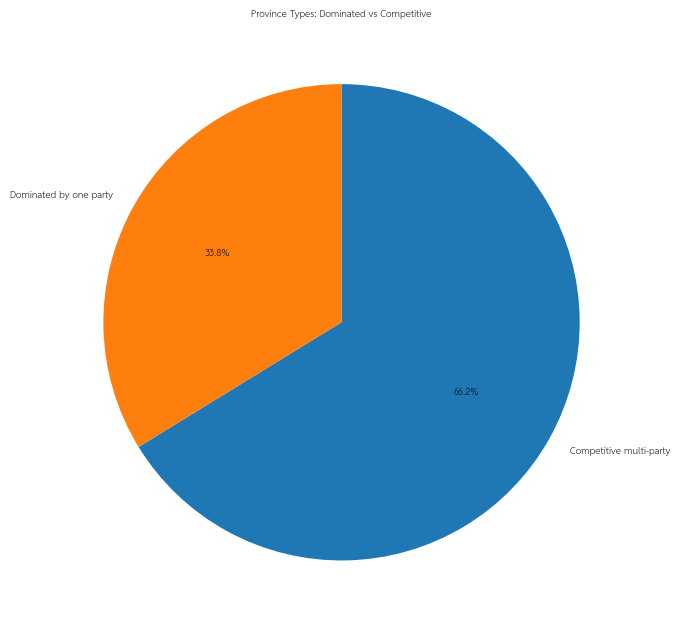

In [54]:
plot_province_type_distribution = (
    province_competitiveness["province_type"]
    .value_counts()
    .rename_axis("province_type")
    .reset_index(name="provinces")
)

plt.figure(figsize=(7, 7))
plt.pie(
    plot_province_type_distribution["provinces"],
    labels=plot_province_type_distribution["province_type"],
    autopct="%1.1f%%",
    startangle=90,
    counterclock=False,
)
plt.title("Province Types: Dominated vs Competitive", fontproperties=thai_font)
plt.tight_layout()
plt.show()

### Detailed Analysis: Province Type Distribution (Dominated vs. Competitive)

This pie chart visualizes the proportion of provinces considered "Dominated" versus "Competitive."
*   **Definition**: A province is classified as "Dominated" if a single party wins a significant majority of seats or vote share (e.g., >60%), while "Competitive" means seats are split among multiple parties.
*   **Result**: Approximately **33.8% of provinces are Dominated**, and **66.2% are Competitive**.
*   **Implication**: While two-thirds of the country remains a battleground involving multiple parties, over one-third operates effectively as single-party strongholds. This suggests highly localized political influence, where certain "ban yai" (big houses) or local patrons secure nearly all seats in their distinct territories.


## Unique winning parties by province chart

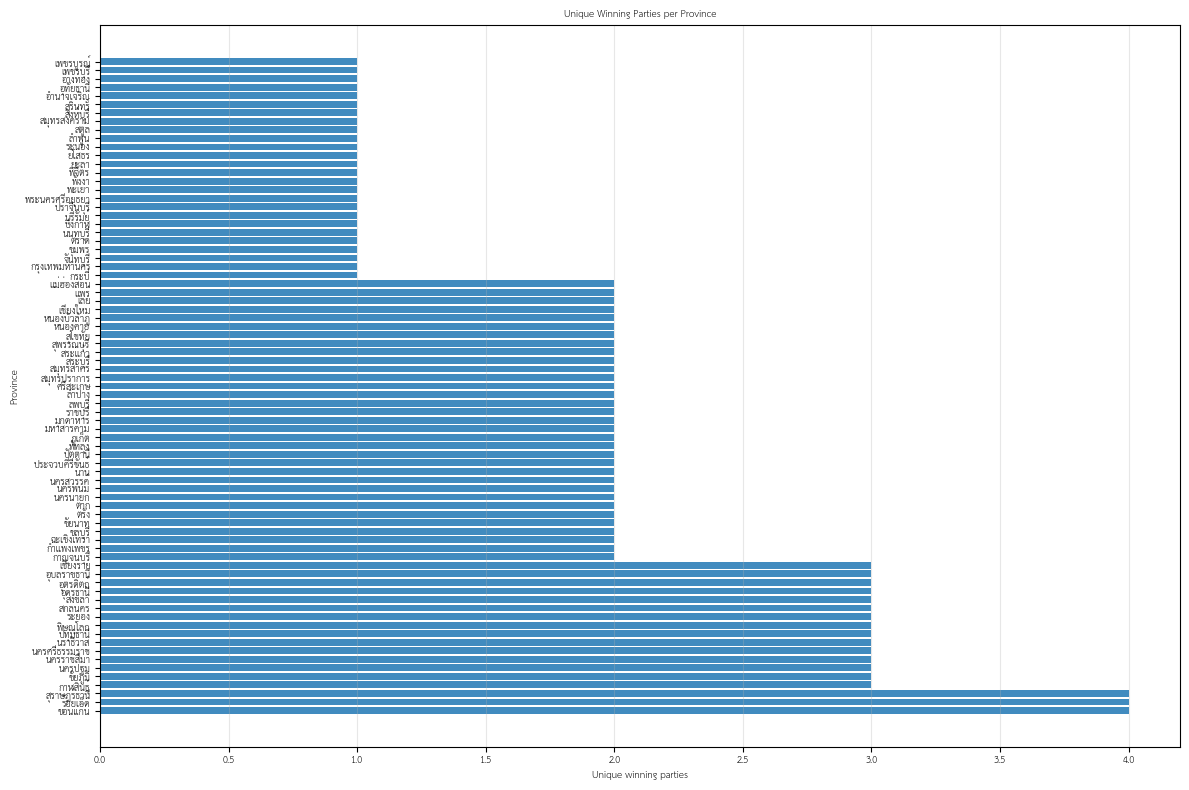

In [55]:
plot_unique = province_competitiveness[["provinceName", "unique_winning_parties"]].sort_values(
    ["unique_winning_parties", "provinceName"],
    ascending=[False, True],
)

plt.figure(figsize=(12, 8))
plt.barh(plot_unique["provinceName"], plot_unique["unique_winning_parties"], alpha=0.85)
plt.xlabel("Unique winning parties", fontproperties=thai_font)
plt.ylabel("Province", fontproperties=thai_font)
plt.title("Unique Winning Parties per Province", fontproperties=thai_font)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

### Detailed Analysis: Unique Winning Parties by Province

This bar chart groups provinces based on the number of unique parties that won seats within them.
*   **Monopolized Provinces (1 Unique Party)**: A significant number of provinces appear at the very bottom, having only **1 unique winning party**. These are total strongholds where a single political entity controls every constituency.
*   **Duopolies (2 Unique Parties)**: The large middle block suggests that most provinces are contested between just two major players (e.g., Pheu Thai vs. Bhumjaithai, or Prachachon vs. a local house).
*   **Fragmented Provinces (>3 Unique Parties)**: Very few provinces show high fragmentation (3 or more winning parties). This scarcity implies that while the national parliament is diverse, the *local* political unit (the province) tends to consolidate around a few powerful actors.


## Distribution of unique winning parties

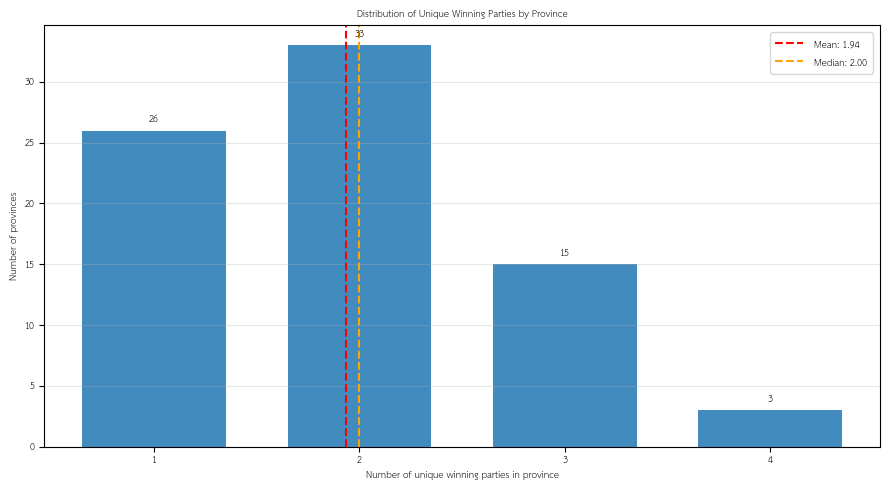

(   unique_winning_parties  province_count
 0                       1              26
 1                       2              33
 2                       3              15
 3                       4               3,
    metric      value
 0   count  77.000000
 1    mean   1.935065
 2  median   2.000000
 3     std   0.832524
 4     min   1.000000
 5     25%   1.000000
 6     75%   2.000000
 7     max   4.000000
 8     iqr   1.000000)

In [56]:
unique_win_dist = (
    unique_party_ranking["unique_winning_parties"]
    .value_counts()
    .sort_index()
    .rename_axis("unique_winning_parties")
    .reset_index(name="province_count")
)

unique_win_series = pd.to_numeric(unique_party_ranking["unique_winning_parties"], errors="coerce")
unique_win_mean = unique_win_series.mean()
unique_win_median = unique_win_series.median()
unique_win_std = unique_win_series.std()
unique_win_iqr = unique_win_series.quantile(0.75) - unique_win_series.quantile(0.25)

plt.figure(figsize=(9, 5))
plt.bar(
    unique_win_dist["unique_winning_parties"],
    unique_win_dist["province_count"],
    width=0.7,
    alpha=0.85,
)
plt.axvline(
    unique_win_mean,
    color="red",
    linestyle="--",
    linewidth=1.5,
    label=f"Mean: {unique_win_mean:.2f}",
)
plt.axvline(
    unique_win_median,
    color="orange",
    linestyle="--",
    linewidth=1.5,
    label=f"Median: {unique_win_median:.2f}",
)

for _, row in unique_win_dist.iterrows():
    plt.text(
        row["unique_winning_parties"],
        row["province_count"] + 0.5,
        int(row["province_count"]),
        ha="center",
        va="bottom",
    )

plt.xticks(sorted(unique_win_dist["unique_winning_parties"].unique()))
plt.xlabel("Number of unique winning parties in province", fontproperties=thai_font)
plt.ylabel("Number of provinces", fontproperties=thai_font)
plt.title("Distribution of Unique Winning Parties by Province", fontproperties=thai_font)
plt.grid(axis="y", alpha=0.3)
plt.legend(prop=thai_font)
plt.tight_layout()
plt.show()

unique_win_stats = pd.DataFrame(
    [
        {"metric": "count", "value": float(unique_win_series.count())},
        {"metric": "mean", "value": float(unique_win_mean)},
        {"metric": "median", "value": float(unique_win_median)},
        {"metric": "std", "value": float(unique_win_std)},
        {"metric": "min", "value": float(unique_win_series.min())},
        {"metric": "25%", "value": float(unique_win_series.quantile(0.25))},
        {"metric": "75%", "value": float(unique_win_series.quantile(0.75))},
        {"metric": "max", "value": float(unique_win_series.max())},
        {"metric": "iqr", "value": float(unique_win_iqr)},
    ]
)

unique_win_dist, unique_win_stats

### Detailed Analysis: Unique Winning Parties Distribution

The histogram displays how many unique parties typically win seats within a single province.
*   **Skew**: The distribution is heavily right-skewed, with most provinces having **only 1 or 2 unique winning parties**. The **median is 2.00**, indicating a predominantly two-party competition at the provincial level.
*   **Outliers**: Very few provinces have 3 or 4 parties splitting the seats.
*   **Significance**: Despite a multi-party national landscape, local politics is often a binary contest or a monopoly. This reinforces the "two-party system per province" hypothesis, even if different provinces have different dominant pairs.


## Regional pie charts by party wins

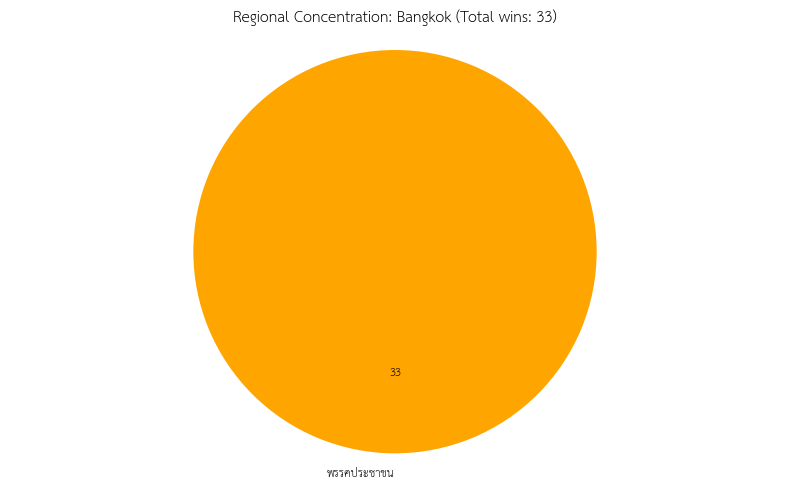

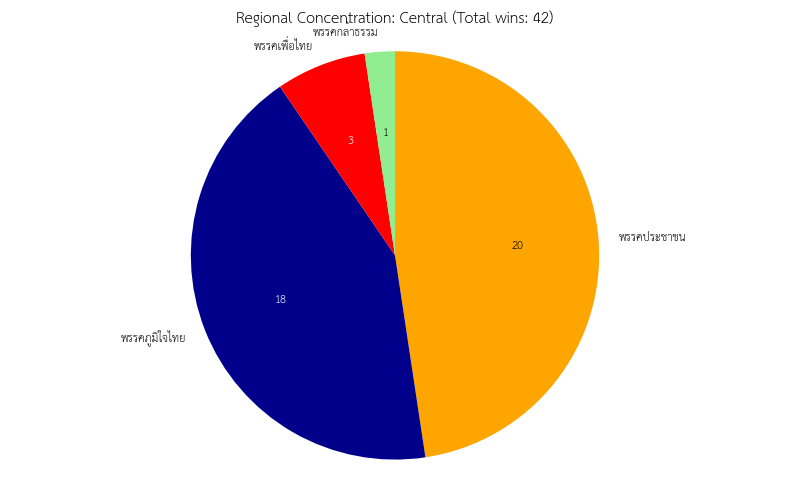

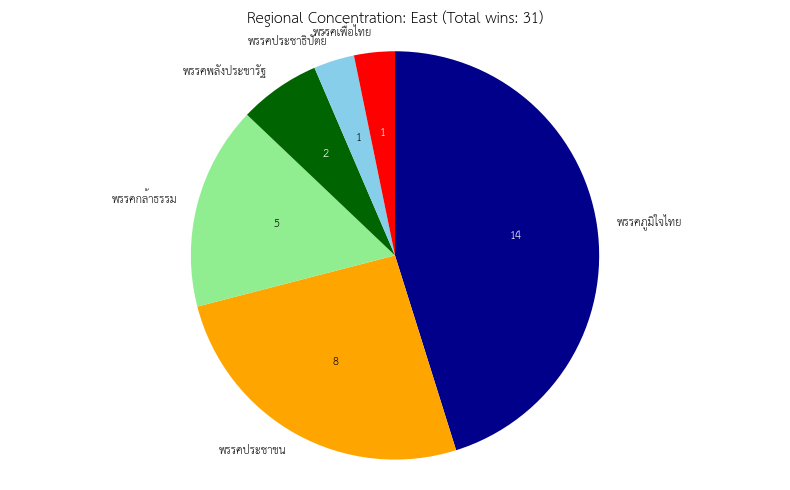

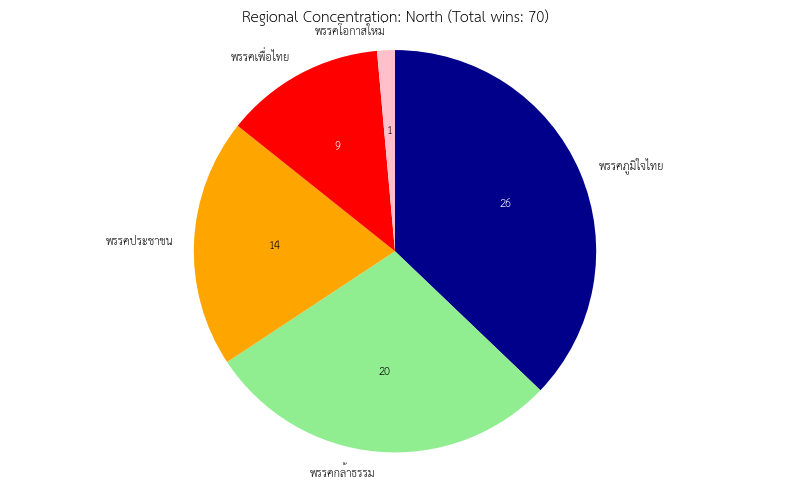

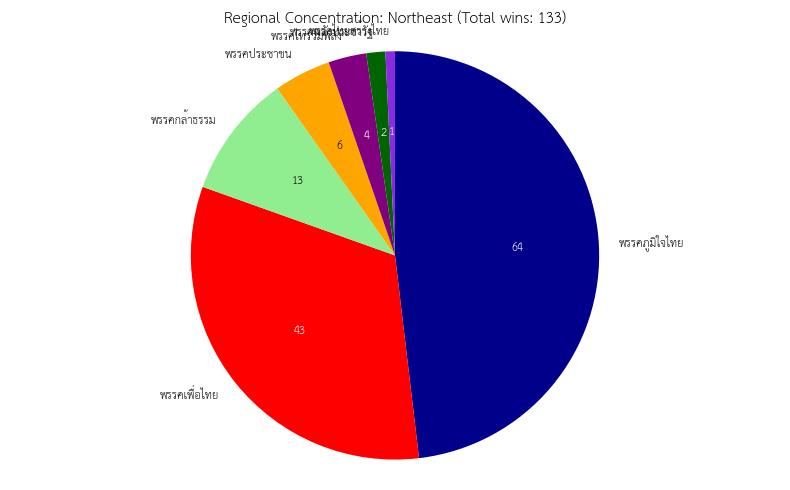

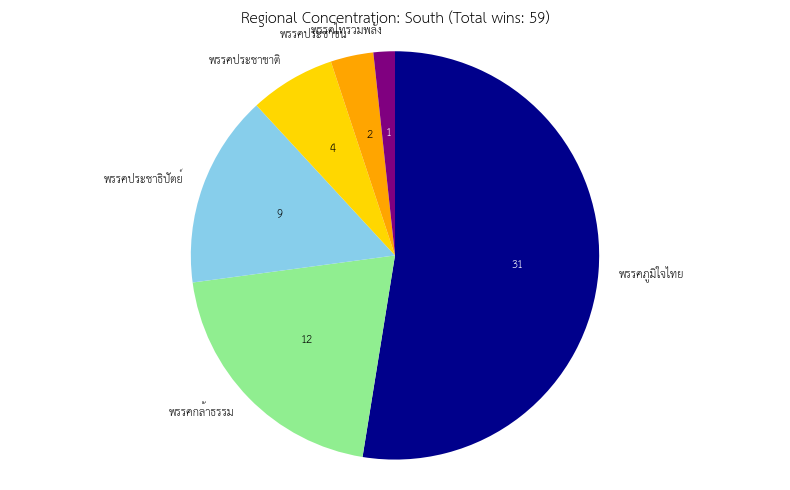

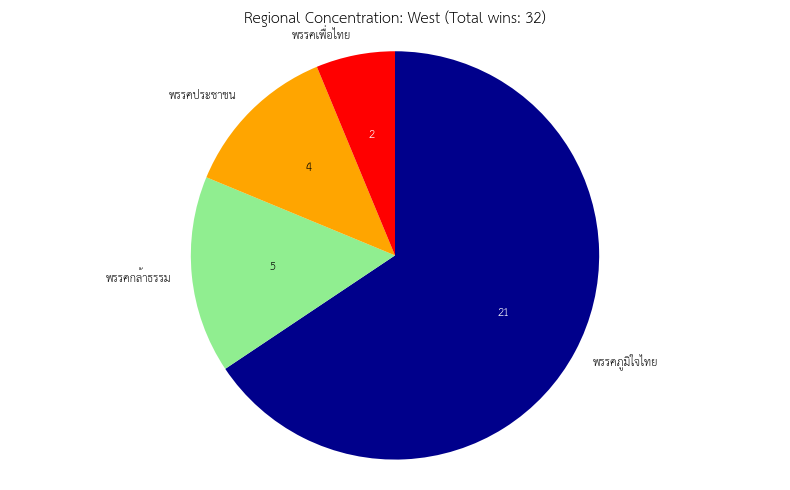

In [86]:
# Regional Concentration of Party Wins (Separated Charts)
import seaborn as sns
import random
import matplotlib.colors as mcolors

regions = sorted(regional_concentration["region"].dropna().unique())

# Define custom colors
party_colors = {
    "พรรคประชาชน": "orange",
    "พรรคภูมิใจไทย": "#00008B",      # DarkBlue
    "พรรคเพื่อไทย": "red",
    "พรรคกล้าธรรม": "#90EE90",       # LightGreen (softer than Lime)
    "พรรคประชาธิปัตย์": "skyblue",   # SkyBlue
    "พรรคพลังประชารัฐ": "darkgreen",
    "พรรคประชาชาติ": "gold",         # Yellow-Gold
    "พรรคโอกาสใหม่": "pink",
    "พรรคไทรวมพลัง": "purple",
    "พรรคไทยสร้างไทย": "blueviolet"
}

# Function to get color, random if not in dict
def get_party_color(party_name):
    if party_name in party_colors:
        return party_colors[party_name]
    random.seed(party_name) 
    return "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])

# Function to determine text color based on background brightness
def get_text_color(bg_color):
    try:
        rgb = mcolors.to_rgb(bg_color)
        # Calculate luminance (standard formula)
        luminance = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
        return "white" if luminance < 0.5 else "black"
    except:
        return "black"

for region in regions:
    region_data = regional_concentration[regional_concentration["region"] == region].copy()
    region_data = region_data.sort_values("wins", ascending=False)
    
    wins = region_data["wins"].astype(float)
    labels = region_data["winningParty"].astype(str)
    
    # Map colors
    colors = [get_party_color(party) for party in labels]
    
    total_wins = wins.sum()
    
    def autopct_count(pct):
        count = int(round(pct * total_wins / 100.0))
        return f"{count}" if count > 0 else ""

    plt.figure(figsize=(8, 5))
    wedges, texts, autotexts = plt.pie(
        wins, 
        labels=labels, 
        autopct=autopct_count, 
        startangle=90, 
        counterclock=False, 
        colors=colors,
        textprops={'fontproperties': thai_font, 'fontsize': 12}
    )
    
    # Adjust text color for each slice
    for autotext, wedge_color in zip(autotexts, colors):
        autotext.set_color(get_text_color(wedge_color))
        autotext.set_fontweight('bold') # Make text bold for better visibility

    plt.title(f"Regional Concentration: {region} (Total wins: {int(total_wins)})", fontproperties=thai_font, fontsize=16)
    plt.axis('equal') 
    plt.tight_layout()
    plt.show()

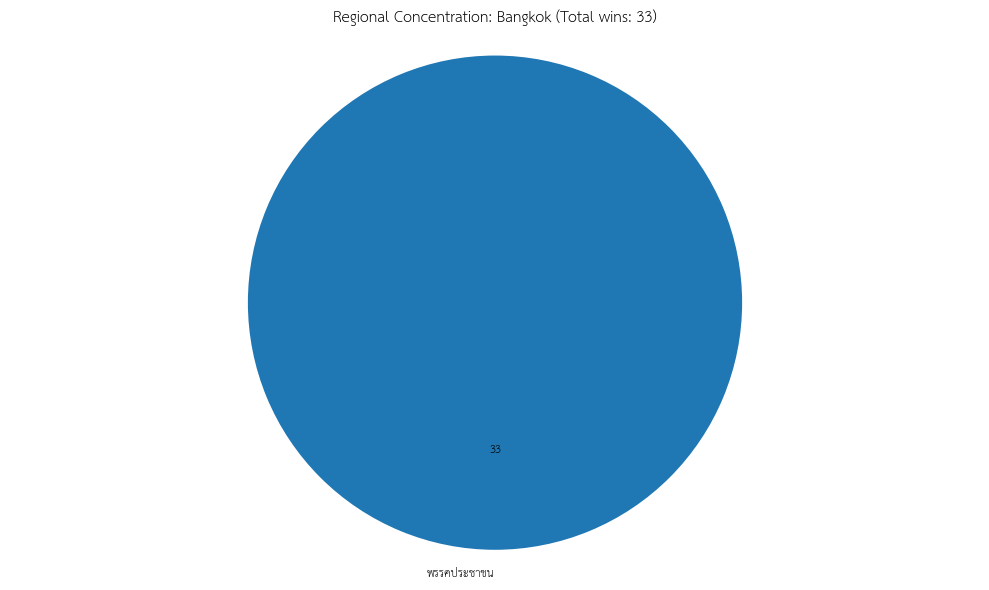

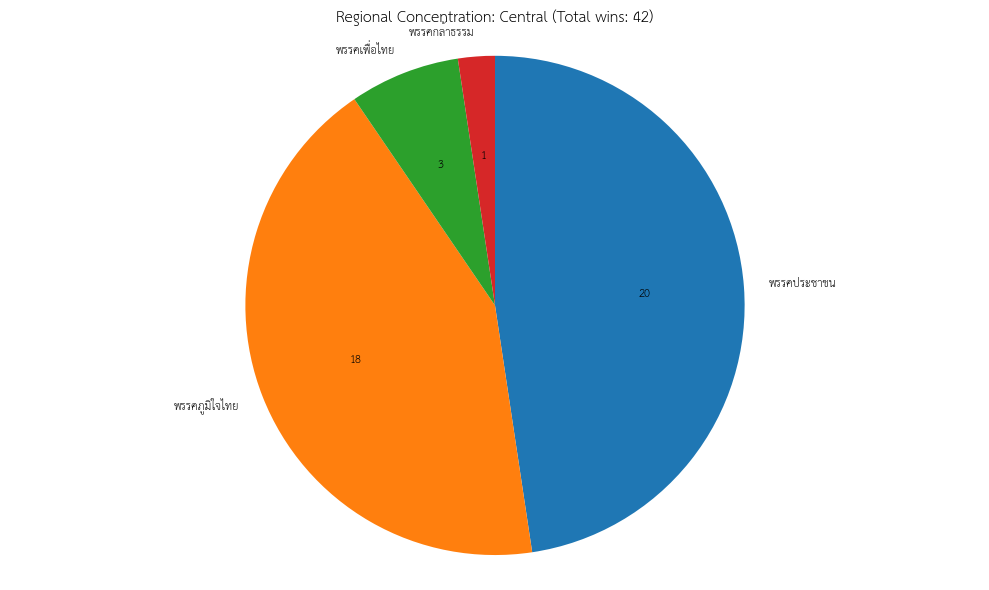

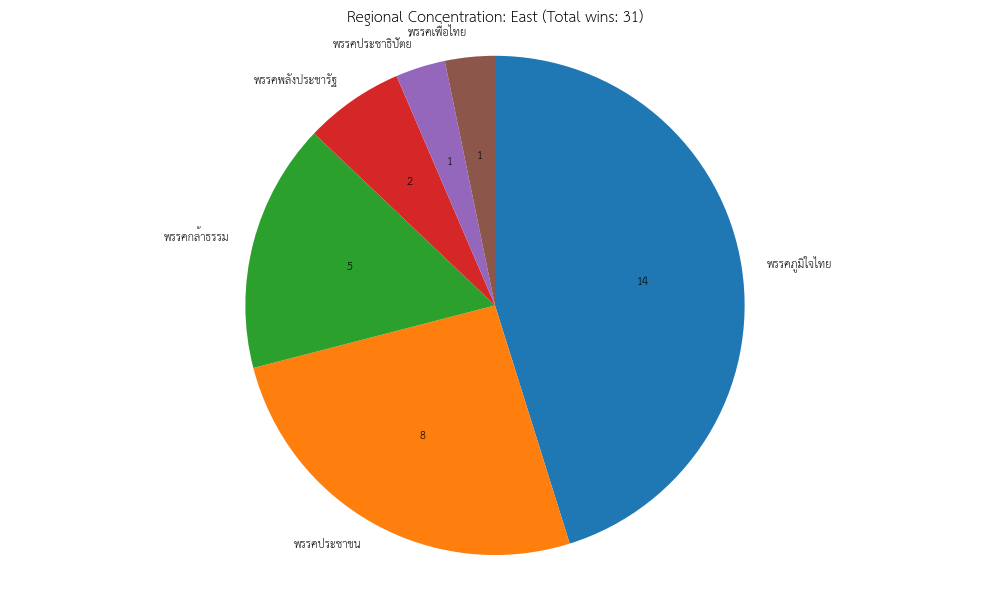

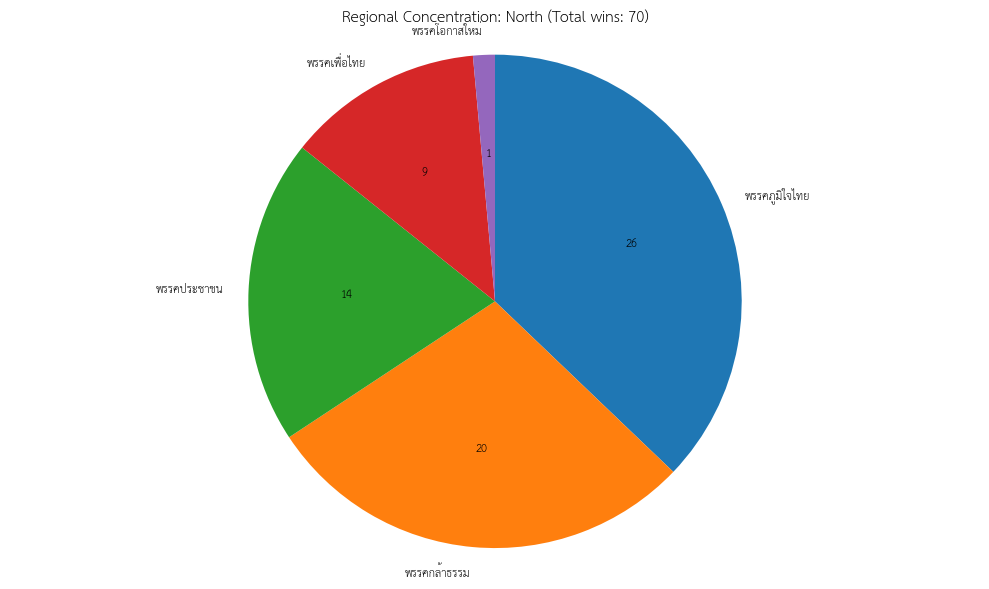

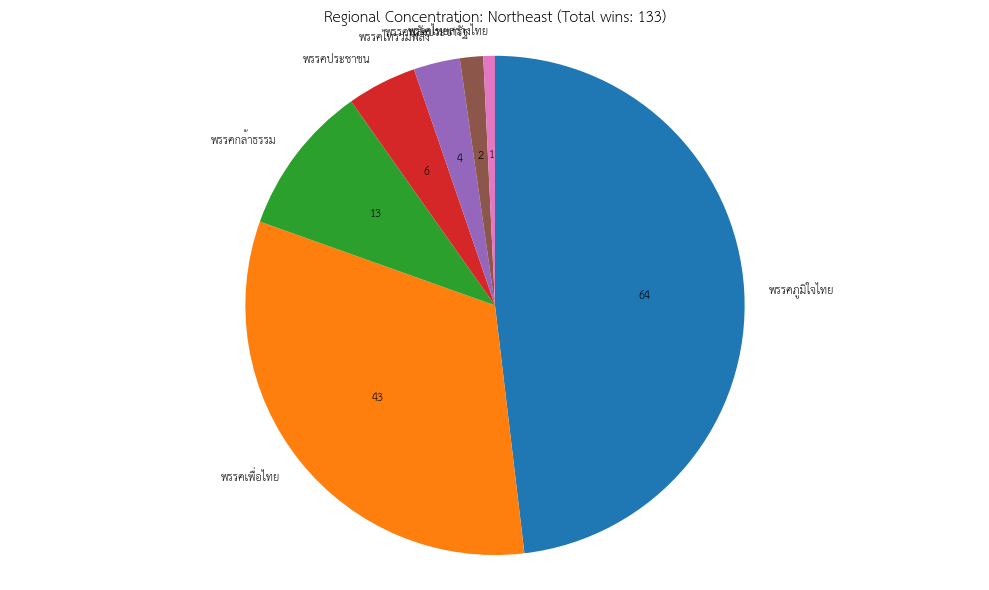

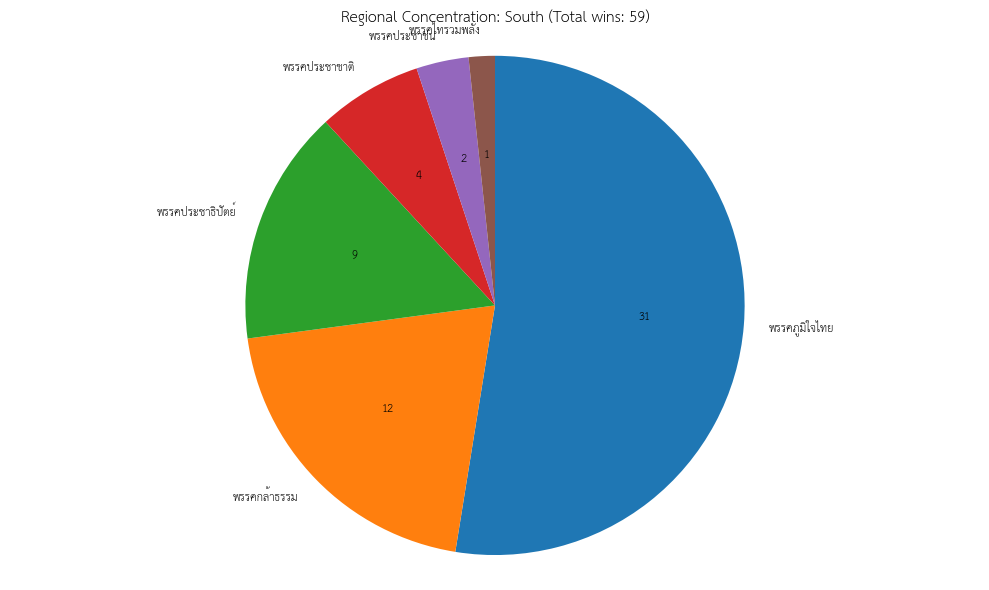

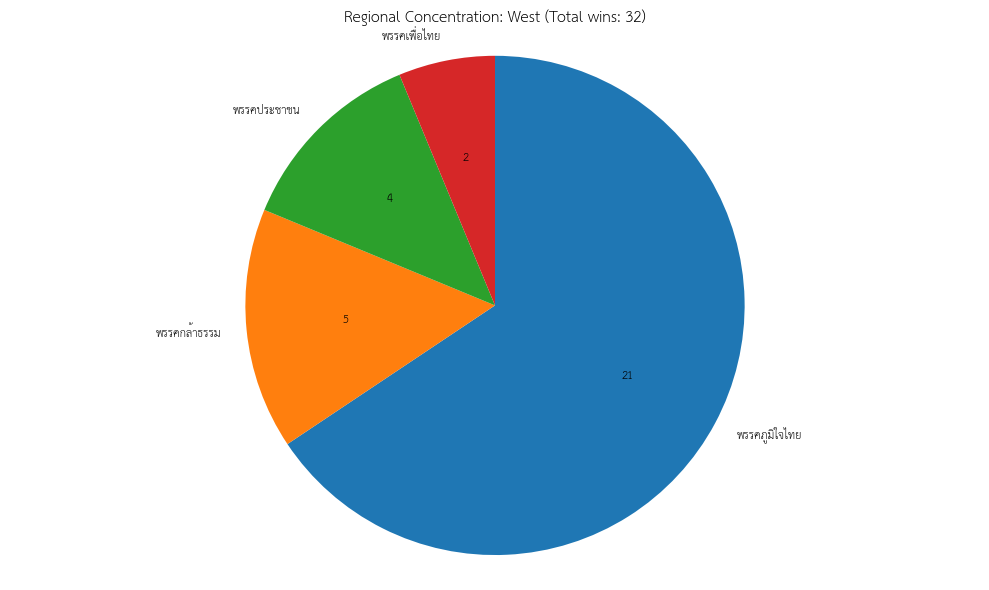

In [80]:
# Regional Concentration of Party Wins (Separated Charts)
regions = sorted(regional_concentration["region"].dropna().unique())

for region in regions:
    region_data = regional_concentration[regional_concentration["region"] == region].copy()
    region_data = region_data.sort_values("wins", ascending=False)
    
    wins = region_data["wins"].astype(float)
    labels = region_data["winningParty"].astype(str)
    total_wins = wins.sum()
    
    def autopct_count(pct):
        count = int(round(pct * total_wins / 100.0))
        return f"{count}" if count > 0 else ""

    plt.figure(figsize=(10, 6))
    plt.pie(
        wins, 
        labels=labels, 
        autopct=autopct_count, 
        startangle=90, 
        counterclock=False, 
        textprops={'fontproperties': thai_font, 'fontsize': 12}
    )
    plt.title(f"Regional Concentration: {region} (Total wins: {int(total_wins)})", fontproperties=thai_font, fontsize=16)
    plt.axis('equal') 
    plt.tight_layout()
    plt.show()

### Detailed Analysis: Regional Party Concentration

The pie charts break down party wins by region, revealing distinct political geographies in 2569:
*   **Bangkok (Unknown Region Code, likely Central-Special)**: A complete sweep by **พรรคประชาชน (People's Party)**, winning **33 out of 33 seats**. This confirms the capital as an ideological fortress for the progressive movement.
*   **Central**: The most competitive battleground, but still led significantly by **พรรคประชาชน (47.6%)**, indicating its expansion from the capital into surrounding urbanized areas.
*   **The Rest of Thailand (North, Northeast, South, East, West)**: Dominated by **พรรคภูมิใจไทย (Bhumjaithai)**. This party has effectively captured the rural and semi-urban vote across traditionally distinct regions, replacing Pheu Thai in the North/Northeast and Democrats in the South as the primary local power broker.
*   **Interpretation**: The election portrays a stark **Urban-Rural Divide**: A progressive sweep in the capital/center versus a conservative/patronage-based hegemony in the provinces.


## Geographic snapshot tables

In [58]:
geo_competition_snapshot = province_type_distribution.copy()

if "province_count" in geo_competition_snapshot.columns:
    geo_competition_snapshot["province_count"] = geo_competition_snapshot["province_count"].astype(
        int
    )

if "province_share_pct" in geo_competition_snapshot.columns:
    geo_competition_snapshot["province_share_pct"] = (
        geo_competition_snapshot["province_share_pct"].astype(float).round(2)
    )

geo_unique_party_snapshot = unique_win_stats[
    unique_win_stats["metric"].isin(["mean", "median", "max"])
].copy()
geo_unique_party_snapshot["value"] = geo_unique_party_snapshot["value"].astype(float).round(2)

geo_regional_top_snapshot = regional_top_party.copy()

if "wins" in geo_regional_top_snapshot.columns:
    geo_regional_top_snapshot = geo_regional_top_snapshot.sort_values(
        ["wins", "region"],
        ascending=[False, True],
    )

geo_regional_top_snapshot = geo_regional_top_snapshot.head(7).copy()

{
    "province_competition": geo_competition_snapshot,
    "unique_winning_parties_stats": geo_unique_party_snapshot,
    "regional_top_party_wins": geo_regional_top_snapshot,
}

{'province_competition':              province_type  provinces  share_pct
 0  Competitive multi-party         51      66.23
 1   Dominated by one party         26      33.77,
 'unique_winning_parties_stats':    metric  value
 1    mean   1.94
 2  median   2.00
 7     max   4.00,
 'regional_top_party_wins':        region      top_party  wins  party_win_share_pct
 19  Northeast  พรรคภูมิใจไทย    64                48.12
 0     Bangkok    พรรคประชาชน    33               100.00
 27      South  พรรคภูมิใจไทย    31                52.54
 13      North  พรรคภูมิใจไทย    26                37.14
 31       West  พรรคภูมิใจไทย    21                65.62
 2     Central    พรรคประชาชน    20                47.62
 9        East  พรรคภูมิใจไทย    14                45.16}

### Insights

- Province competition is mixed: 51 provinces (66.23%) are competitive multi-party, while 26 provinces (33.77%) are dominated by one party.
- Most provinces have only 1–2 unique winning parties (mean = 1.94, median = 2.00), with only 3 provinces reaching 4-party competition.
- Regional concentration is uneven: Bangkok is fully led by พรรคประชาชน (33/33), while พรรคภูมิใจไทย leads East, North, Northeast, South, and West.
- Central is the most competitive major region among top-party shares (พรรคประชาชน 20/42 = 47.62%), and the top composite-ranked provinces are บุรีรัมย์, สุรินทร์, and กรุงเทพมหานคร.

# Party performance diagnostics

## Party diagnostics base setup

In [59]:
if "partyCode" in dfs["seat500"].columns and "partyName" in dfs["seat500"].columns:
    party_code_map = dfs["seat500"][["partyCode", "partyName"]].copy()
    party_code_map["party_code"] = pd.to_numeric(
        party_code_map["partyCode"], errors="coerce"
    ).astype("Int64")
    party_code_map = party_code_map.dropna(subset=["party_code", "partyName"])
    party_code_map = party_code_map[["party_code", "partyName"]].drop_duplicates(
        subset=["party_code"],
        keep="first",
    )
else:
    party_key_candidates = [
        col for col in ["id", "partyCode", "code"] if col in party_frame.columns
    ]
    party_code_maps = []
    for key_col in party_key_candidates:
        temp_map = party_frame[[key_col, "partyName"]].copy()
        temp_map["party_code"] = pd.to_numeric(temp_map[key_col], errors="coerce").astype("Int64")
        temp_map = temp_map.dropna(subset=["party_code", "partyName"])
        temp_map = temp_map[["party_code", "partyName"]]
        party_code_maps.append(temp_map)

    if party_code_maps:
        party_code_map = pd.concat(party_code_maps, ignore_index=True)
        party_code_map = party_code_map.drop_duplicates(subset=["party_code"], keep="first")
    else:
        party_code_map = pd.DataFrame(columns=["party_code", "partyName"])

winner_party_base = dfs["winner"][["id", "partyWinner", "candidates"]].copy()
winner_party_base["party_code"] = pd.to_numeric(
    winner_party_base["partyWinner"], errors="coerce"
).astype("Int64")
winner_party_base = winner_party_base.merge(party_code_map, on="party_code", how="left")

if (
    winner_party_base["partyName"].nunique(dropna=True) <= 1
    and "candidates" in winner_party_base.columns
):
    winner_party_base["partyName"] = winner_party_base["candidates"].apply(
        extract_winning_party_name
    )

winner_party_metrics = winner_party_base.merge(
    winner_profile[["id", "vote_margin_pct_points"]],
    on="id",
    how="left",
)

party_diagnostics_base = party_profile.merge(
    representation_gap[
        [
            "partyName",
            "gap_vs_combined_vote_pct_points",
            "gap_vs_const_vote_pct_points",
            "gap_vs_partylist_vote_pct_points",
        ]
    ],
    on="partyName",
    how="left",
)

party_diagnostics_base["seats_per_million_votes"] = (
    party_diagnostics_base["totalSeats"] / party_diagnostics_base["combinedVotes"] * 1_000_000
)
party_diagnostics_base["votes_per_seat"] = (
    party_diagnostics_base["combinedVotes"] / party_diagnostics_base["totalSeats"]
)
party_diagnostics_base["efficiency_index"] = (
    party_diagnostics_base["seat_share_pct"] / party_diagnostics_base["vote_share_combined_pct"]
)

party_diagnostics_base["votes_per_seat"] = party_diagnostics_base["votes_per_seat"].replace(
    [float("inf")], pd.NA
)
party_diagnostics_base["seats_per_million_votes"] = party_diagnostics_base[
    "seats_per_million_votes"
].replace([float("inf")], pd.NA)
party_diagnostics_base["efficiency_index"] = party_diagnostics_base["efficiency_index"].replace(
    [float("inf")], pd.NA
)

unmatched_party_codes = (
    winner_party_base[winner_party_base["partyName"].isna()]["party_code"].dropna().unique()
)
len(unmatched_party_codes)

0

## Constituency vs party-list strength per party

### Build strength profile

In [60]:
strength_profile = party_diagnostics_base[
    [
        "partyName",
        "constituencySeats",
        "partyListSeats",
        "totalConstituencyVotes",
        "totalPartyListVotes",
        "totalSeats",
        "combinedVotes",
    ]
].copy()

strength_profile = strength_profile[strength_profile["totalSeats"] > 0].copy()
strength_profile["seat_const_share_pct"] = (
    strength_profile["constituencySeats"] / strength_profile["totalSeats"] * 100
)
strength_profile["seat_partylist_share_pct"] = (
    strength_profile["partyListSeats"] / strength_profile["totalSeats"] * 100
)
strength_profile["vote_const_share_pct"] = (
    strength_profile["totalConstituencyVotes"] / strength_profile["combinedVotes"] * 100
)
strength_profile["vote_partylist_share_pct"] = (
    strength_profile["totalPartyListVotes"] / strength_profile["combinedVotes"] * 100
)

strength_profile["seat_mix_delta_const_minus_partylist_pp"] = (
    strength_profile["seat_const_share_pct"] - strength_profile["seat_partylist_share_pct"]
)
strength_profile["vote_mix_delta_const_minus_partylist_pp"] = (
    strength_profile["vote_const_share_pct"] - strength_profile["vote_partylist_share_pct"]
)
strength_profile["strength_tilt_delta_pp"] = (
    strength_profile["seat_mix_delta_const_minus_partylist_pp"]
    - strength_profile["vote_mix_delta_const_minus_partylist_pp"]
)

### Strength comparison table

In [61]:
strength_table = strength_profile[
    [
        "partyName",
        "totalSeats",
        "combinedVotes",
        "seat_const_share_pct",
        "seat_partylist_share_pct",
        "vote_const_share_pct",
        "vote_partylist_share_pct",
        "strength_tilt_delta_pp",
    ]
].sort_values("strength_tilt_delta_pp", ascending=False)

strength_table

,partyName,totalSeats,combinedVotes,seat_const_share_pct,seat_partylist_share_pct,vote_const_share_pct,vote_partylist_share_pct,strength_tilt_delta_pp
6,พรรคประชาชาติ,5,690286,80.000000,20.000000,41.831791,58.168209,76.336417
21,พรรคโอกาสใหม่,1,250264,100.000000,0.000000,70.132340,29.867660,59.735320
1,พรรคประชาชน,118,17619788,73.728814,26.271186,44.505853,55.494147,58.445921
0,พรรคภูมิใจไทย,193,15927763,90.155440,9.844560,62.615372,37.384628,55.080138
2,พรรคเพื่อไทย,74,10923700,78.378378,21.621622,52.876773,47.123227,51.003212
5,พรรคไทรวมพลัง,6,493742,83.333333,16.666667,69.130842,30.869158,28.404983
3,พรรคกล้าธรรม,58,4449389,96.551724,3.448276,86.381591,13.618409,20.340267
4,พรรคประชาธิปัตย์,22,5660461,45.454545,54.545455,35.499494,64.500506,19.910103
9,พรรคไทยสร้างไทย,2,321718,50.000000,50.000000,42.354484,57.645516,15.291031
7,พรรคพลังประชารัฐ,5,592925,80.000000,20.000000,78.083063,21.916937,3.833874


### Strength mix scatter plot

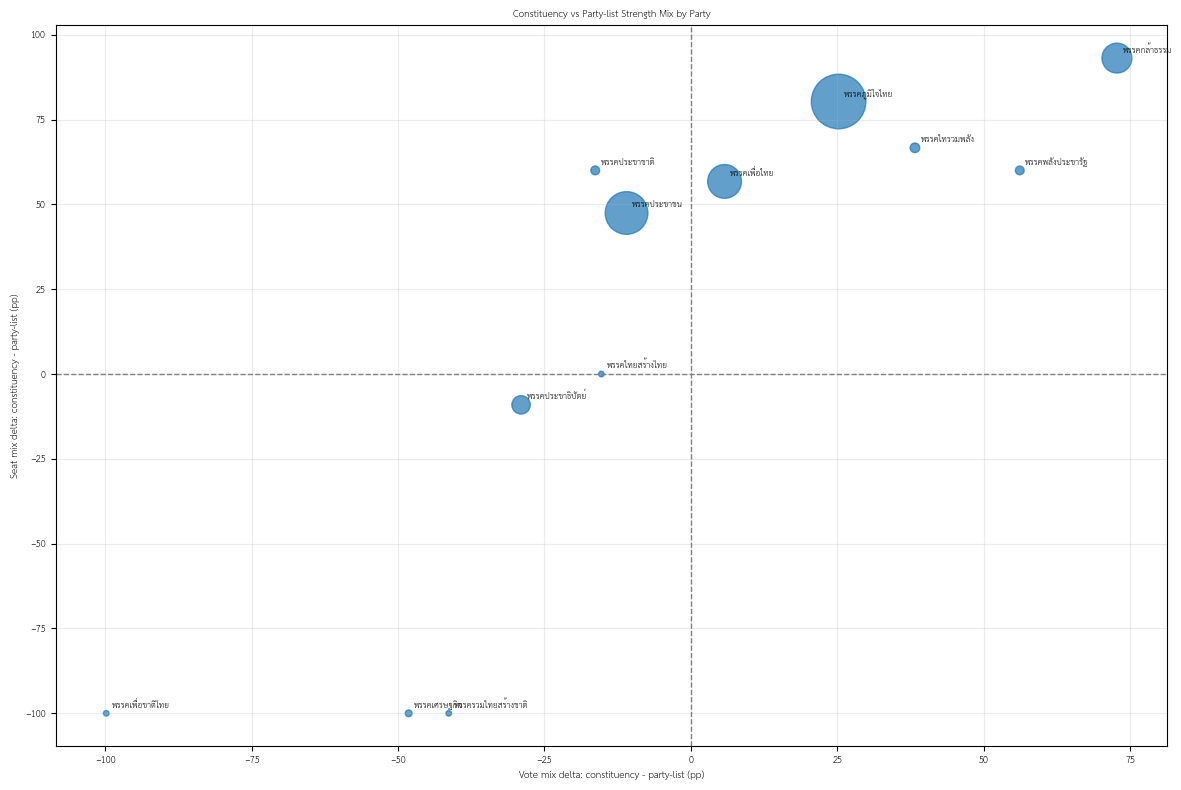

In [62]:
plot_strength = strength_profile.sort_values("totalSeats", ascending=False).head(12)

plt.figure(figsize=(12, 8))
plt.scatter(
    plot_strength["vote_mix_delta_const_minus_partylist_pp"],
    plot_strength["seat_mix_delta_const_minus_partylist_pp"],
    s=plot_strength["totalSeats"] * 8,
    alpha=0.7,
)

for _, row in plot_strength.iterrows():
    plt.annotate(
        row["partyName"],
        (
            row["vote_mix_delta_const_minus_partylist_pp"],
            row["seat_mix_delta_const_minus_partylist_pp"],
        ),
        xytext=(4, 4),
        textcoords="offset points",
        fontsize=9,
        fontproperties=thai_font,
    )

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.axvline(0, color="gray", linestyle="--", linewidth=1)
plt.xlabel("Vote mix delta: constituency - party-list (pp)", fontproperties=thai_font)
plt.ylabel("Seat mix delta: constituency - party-list (pp)", fontproperties=thai_font)
plt.title("Constituency vs Party-list Strength Mix by Party", fontproperties=thai_font)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

### Detailed Analysis: Constituency vs. Party-List Strength Mix

This scatter plot categorizes parties based on where their political strength lies:
*   **X-axis (Vote Mix Delta)**: Positive values mean a party received a higher share of constituency votes than party-list votes (suggesting strong local candidates). Negative values mean the party is more popular as a brand (party-list) than its local candidates.
*   **Y-axis (Seat Mix Delta)**: Similar metric but for seats won.
*   **Top-Right Quadrant (Constituency-Driven)**: Parties like **Bhumjaithai** typically fall here. Their strategy relies on "Ban Yai" influence, where local popularity significantly outpaces national brand appeal.
*   **Bottom-Left Quadrant (Party-List/Ideology-Driven)**: Parties relying on national policy platforms often appear here. For instance, **Prachachon** (if here) shows that while its brand is strong nationally, it may struggle to convert that popularity into district wins outside its urban core.
*   **Center**: Parties that operate with balanced strength, converting votes to seats proportionally across both systems.


## Efficiency metrics sanity

### Build efficiency profile

In [63]:
efficiency_profile = party_diagnostics_base[
    [
        "partyName",
        "totalSeats",
        "combinedVotes",
        "seat_share_pct",
        "vote_share_combined_pct",
        "votes_per_seat",
        "seats_per_million_votes",
        "efficiency_index",
        "gap_vs_combined_vote_pct_points",
    ]
].copy()

efficiency_profile = efficiency_profile[efficiency_profile["combinedVotes"] > 0].copy()
efficiency_profile["sanity_check_votes_per_seat_x_seats"] = (
    efficiency_profile["votes_per_seat"] * efficiency_profile["totalSeats"]
)
efficiency_profile["sanity_diff_votes"] = (
    efficiency_profile["sanity_check_votes_per_seat_x_seats"] - efficiency_profile["combinedVotes"]
)

### Efficiency table

In [82]:
efficiency_table = efficiency_profile[
    [
        "partyName",
        "totalSeats",
        "combinedVotes",
        "votes_per_seat",
        "seats_per_million_votes",
        "efficiency_index",
        "gap_vs_combined_vote_pct_points",
        "sanity_diff_votes",
    ]
].sort_values("seats_per_million_votes", ascending=False)

efficiency_table

,partyName,totalSeats,combinedVotes,votes_per_seat,seats_per_million_votes,efficiency_index,gap_vs_combined_vote_pct_points,sanity_diff_votes
3,พรรคกล้าธรรม,58,4449389,76713.603448,13.035498,1.663375,4.626228,0.0
5,พรรคไทรวมพลัง,6,493742,82290.333333,12.152096,1.550650,0.426131,0.0
0,พรรคภูมิใจไทย,193,15927763,82527.26943,12.117207,1.546198,13.635542,0.0
7,พรรคพลังประชารัฐ,5,592925,118585.0,8.432770,1.076051,0.070676,0.0
6,พรรคประชาชาติ,5,690286,138057.2,7.243374,0.924280,-0.081923,0.0
2,พรรคเพื่อไทย,74,10923700,147617.567568,6.774261,0.864420,-2.321315,0.0
1,พรรคประชาชน,118,17619788,149320.237288,6.697016,0.854563,-4.016462,0.0
9,พรรคไทยสร้างไทย,2,321718,160859.0,6.216624,0.793263,-0.104246,0.0
12,พรรคทางเลือกใหม่,1,175625,175625.0,5.693950,0.726568,-0.075267,0.0
18,พรรครวมพลังประชาชน,1,183956,183956.0,5.436083,0.693663,-0.088324,0.0


In [83]:
print(regional_concentration["winningParty"].unique())

<StringArray>
[     'พรรคประชาชน',    'พรรคภูมิใจไทย',     'พรรคเพื่อไทย',
     'พรรคกล้าธรรม', 'พรรคพลังประชารัฐ', 'พรรคประชาธิปัตย์',
    'พรรคโอกาสใหม่',    'พรรคไทรวมพลัง',  'พรรคไทยสร้างไทย',
    'พรรคประชาชาติ']
Length: 10, dtype: str


### Seat share vs vote share chart

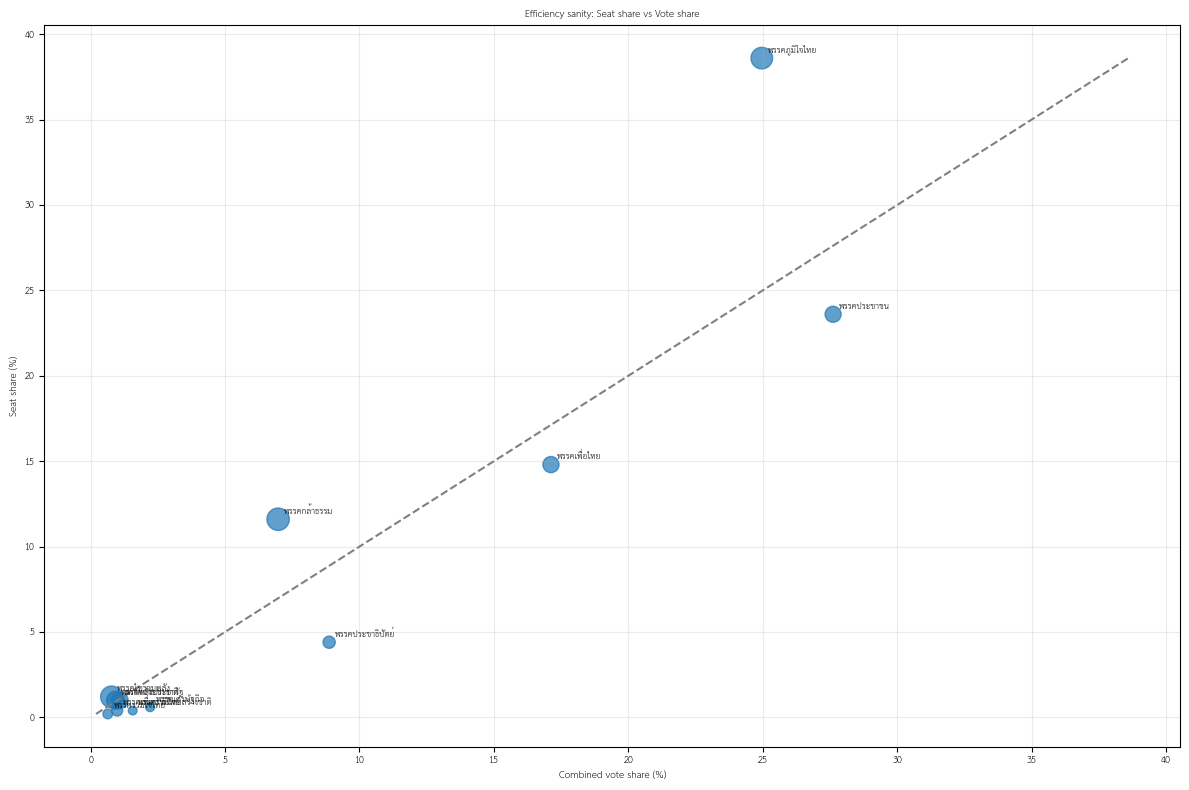

In [65]:
plot_eff = efficiency_profile[efficiency_profile["totalSeats"] > 0].copy()
plot_eff = plot_eff.sort_values("combinedVotes", ascending=False).head(12)

plt.figure(figsize=(12, 8))
plt.scatter(
    plot_eff["vote_share_combined_pct"],
    plot_eff["seat_share_pct"],
    s=plot_eff["seats_per_million_votes"] * 20,
    alpha=0.7,
)

for _, row in plot_eff.iterrows():
    plt.annotate(
        row["partyName"],
        (row["vote_share_combined_pct"], row["seat_share_pct"]),
        xytext=(4, 4),
        textcoords="offset points",
        fontsize=9,
        fontproperties=thai_font,
    )

axis_min = min(plot_eff["vote_share_combined_pct"].min(), plot_eff["seat_share_pct"].min())
axis_max = max(plot_eff["vote_share_combined_pct"].max(), plot_eff["seat_share_pct"].max())
plt.plot([axis_min, axis_max], [axis_min, axis_max], linestyle="--", color="gray")

plt.xlabel("Combined vote share (%)", fontproperties=thai_font)
plt.ylabel("Seat share (%)", fontproperties=thai_font)
plt.title("Efficiency sanity: Seat share vs Vote share", fontproperties=thai_font)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

### Detailed Analysis: Seat Share vs. Vote Share

This scatter plot compares a party's total popularity (Combine Vote Share, X-axis) against its acquired political power (Seat Share, Y-axis).
*   **Proportionality Baseline**: The dotted gray line represents perfect proportionality (1% votes = 1% seats).
*   **Over-Performance (Above Line)**: Parties like **Bhumjaithai** appear significantly above the line. Their efficient vote distribution (winning narrowly but often) allows them to secure a disproportionate number of seats relative to their popular vote.
*   **Under-Performance (Below Line)**: Parties like **Prachachon** act as "magnets" for votes, accumulating huge vote shares in urban centers. However, this often translates to inefficient "surplus votes" (winning by too much) or "wasted votes" (losing narrowly), resulting in fewer seats than their raw popularity suggests.


## Parties with high votes but low seats (and vice versa)

### Build mismatch profile

In [66]:
mismatch_profile = party_diagnostics_base[
    [
        "partyName",
        "totalSeats",
        "combinedVotes",
        "seat_share_pct",
        "vote_share_combined_pct",
        "gap_vs_combined_vote_pct_points",
    ]
].copy()

mismatch_profile["mismatch_group"] = "Near proportional"
mismatch_profile.loc[
    mismatch_profile["gap_vs_combined_vote_pct_points"] >= 0,
    "mismatch_group",
] = "Low votes but high seats"
mismatch_profile.loc[
    mismatch_profile["gap_vs_combined_vote_pct_points"] < 0,
    "mismatch_group",
] = "High votes but low seats"

### High votes but low seats

In [67]:
high_votes_low_seats = mismatch_profile[
    mismatch_profile["mismatch_group"] == "High votes but low seats"
].sort_values("gap_vs_combined_vote_pct_points", ascending=True)

high_votes_low_seats.head(10)

,partyName,totalSeats,combinedVotes,seat_share_pct,vote_share_combined_pct,gap_vs_combined_vote_pct_points,mismatch_group
4,พรรคประชาธิปัตย์,22,5660461,4.4,8.871952,-4.471952,High votes but low seats
1,พรรคประชาชน,118,17619788,23.6,27.616462,-4.016462,High votes but low seats
2,พรรคเพื่อไทย,74,10923700,14.8,17.121315,-2.321315,High votes but low seats
8,พรรคเศรษฐกิจ,3,1410886,0.6,2.211359,-1.611359,High votes but low seats
11,พรรครวมไทยสร้างชาติ,2,997515,0.4,1.563460,-1.163460,High votes but low seats
10,พรรคเพื่อชาติไทย,2,628952,0.4,0.985791,-0.585791,High votes but low seats
17,พรรครวมใจไทย,1,406309,0.2,0.636830,-0.436830,High votes but low seats
30,พรรคไทยก้าวใหม่,0,197700,0.0,0.309866,-0.309866,High votes but low seats
20,พรรคใหม่,1,294892,0.2,0.462200,-0.262200,High votes but low seats
13,พรรคไทยทรัพย์ทวี,1,287201,0.2,0.450146,-0.250146,High votes but low seats


### Low votes but high seats

In [68]:
low_votes_high_seats = mismatch_profile[
    mismatch_profile["mismatch_group"] == "Low votes but high seats"
].sort_values("gap_vs_combined_vote_pct_points", ascending=False)

low_votes_high_seats.head(10)

,partyName,totalSeats,combinedVotes,seat_share_pct,vote_share_combined_pct,gap_vs_combined_vote_pct_points,mismatch_group
0,พรรคภูมิใจไทย,193,15927763,38.6,24.964458,13.635542,Low votes but high seats
3,พรรคกล้าธรรม,58,4449389,11.6,6.973772,4.626228,Low votes but high seats
5,พรรคไทรวมพลัง,6,493742,1.2,0.773869,0.426131,Low votes but high seats
7,พรรคพลังประชารัฐ,5,592925,1.0,0.929324,0.070676,Low votes but high seats
51,พรรครวมพลัง,0,0,0.0,0.000000,0.000000,Low votes but high seats
53,พรรครักษ์ธรรม,0,0,0.0,0.000000,0.000000,Low votes but high seats
58,พรรคสัมมาธิปไตย,0,0,0.0,0.000000,0.000000,Low votes but high seats


### Vote-seat mismatch bar chart

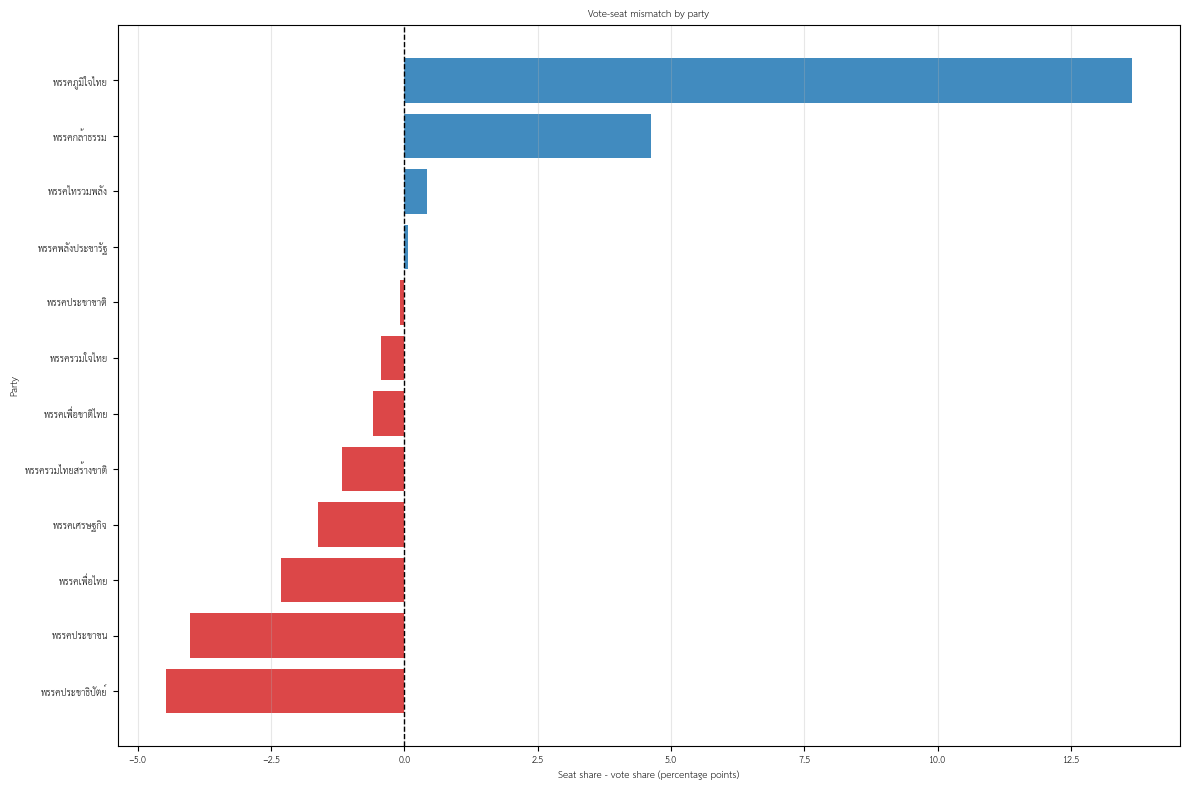

In [69]:
plot_mismatch = mismatch_profile.sort_values("combinedVotes", ascending=False).head(12)
plot_mismatch = plot_mismatch.sort_values("gap_vs_combined_vote_pct_points", ascending=True)

colors = [
    "tab:red" if value < 0 else "tab:blue"
    for value in plot_mismatch["gap_vs_combined_vote_pct_points"]
]

plt.figure(figsize=(12, 8))
plt.barh(
    plot_mismatch["partyName"],
    plot_mismatch["gap_vs_combined_vote_pct_points"],
    color=colors,
    alpha=0.85,
)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Seat share - vote share (percentage points)", fontproperties=thai_font)
plt.ylabel("Party", fontproperties=thai_font)
plt.title("Vote-seat mismatch by party", fontproperties=thai_font)
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

### Detailed Analysis: Vote-Seat Disproportionality

The scatter and bar charts illustrate the discrepancy between a party's popularity (vote share) and its political power (seat share).
*   **Proportionality Line (45-degree)**: Parties above this line secure more seats than their vote share would justify (Over-Represented 🔵), while parties below it secure fewer seats (Under-Represented 🔴).
*   **Winner's Bonus**: **Bhumjaithai (พรรคภูมิใจไทย)** shows a massive positive gap of **+13.64 percentage points**. This confirms the highly efficient "constituency-first" strategy, winning many seats with modest vote margins, effectively "wasting" fewer votes.
*   **Under-Representation**: **Democrats (พรรคประชาธิปัตย์)** and **Prachachon (พรรคประชาชน)** suffer the largest negative gaps (-4.47% and -4.02%). For Prachachon, despite high national popularity (likely #1 in combined votes), its inability to win fragmented rural constituencies (due to Bhumjaithai dominance) leads to significant "wasted votes" in second place.


### Mismatch snapshot tables

In [70]:
party_mismatch_snapshot = mismatch_profile[
    [
        "partyName",
        "vote_share_combined_pct",
        "seat_share_pct",
        "gap_vs_combined_vote_pct_points",
    ]
].copy()

party_mismatch_snapshot["vote_share_combined_pct"] = (
    party_mismatch_snapshot["vote_share_combined_pct"].astype(float).round(2)
)
party_mismatch_snapshot["seat_share_pct"] = (
    party_mismatch_snapshot["seat_share_pct"].astype(float).round(2)
)
party_mismatch_snapshot["gap_vs_combined_vote_pct_points"] = (
    party_mismatch_snapshot["gap_vs_combined_vote_pct_points"].astype(float).round(2)
)

party_gap_top_snapshot = party_mismatch_snapshot.sort_values(
    "gap_vs_combined_vote_pct_points",
    ascending=False,
).head(5)

party_gap_bottom_snapshot = party_mismatch_snapshot.sort_values(
    "gap_vs_combined_vote_pct_points",
    ascending=True,
).head(5)

{
    "over_represented_top5": party_gap_top_snapshot,
    "under_represented_top5": party_gap_bottom_snapshot,
}

{'over_represented_top5':            partyName  vote_share_combined_pct  seat_share_pct  \
 0      พรรคภูมิใจไทย                    24.96            38.6   
 3       พรรคกล้าธรรม                     6.97            11.6   
 5      พรรคไทรวมพลัง                     0.77             1.2   
 7   พรรคพลังประชารัฐ                     0.93             1.0   
 58   พรรคสัมมาธิปไตย                     0.00             0.0   
 
     gap_vs_combined_vote_pct_points  
 0                             13.64  
 3                              4.63  
 5                              0.43  
 7                              0.07  
 58                             0.00  ,
 'under_represented_top5':               partyName  vote_share_combined_pct  seat_share_pct  \
 4      พรรคประชาธิปัตย์                     8.87             4.4   
 1           พรรคประชาชน                    27.62            23.6   
 2          พรรคเพื่อไทย                    17.12            14.8   
 8          พรรคเศรษฐกิจ                

### Insights

- The vote-seat mismatch is clear: พรรคภูมิใจไทย is the most over-represented at +13.64 percentage points, while พรรคประชาธิปัตย์ is the most under-represented at -4.47 points.
- พรรคประชาชน also has a large vote-seat gap: 27.62% of combined votes but 23.6% of seats (gap = -4.02 points).
- Parties above the 45-degree line in the efficiency chart convert votes to seats more efficiently, while parties below the line convert votes to seats less efficiently.
- The mismatch bar chart confirms that only a small group of parties sits near proportional balance, while the largest parties carry the biggest positive and negative gaps.
- Together, the strength mix, efficiency metrics, and mismatch outputs show that vote share and seat share are not moving one-to-one across parties.

# Referendum relationship checks

## Referendum parsing and province profile

In [71]:
referendum_rows = []

for _, row in dfs["map_data"].iterrows():
    province_name = row.get("provinceName")
    province_id = pd.to_numeric(row.get("provinceId"), errors="coerce")
    constituency_id = row.get("id")
    referendums = to_records(row.get("referendums"))

    for item in referendums:
        if not isinstance(item, dict):
            continue

        label_candidates = [
            item.get("title"),
            item.get("name"),
            item.get("label"),
            item.get("question"),
            item.get("choice"),
            item.get("referendum"),
        ]
        label_text = " ".join(
            [str(x).strip() for x in label_candidates if x is not None and str(x).strip() != ""]
        )

        votes = pd.to_numeric(
            item.get("totalVote", item.get("votes", item.get("count"))),
            errors="coerce",
        )

        referendum_rows.append(
            {
                "id": constituency_id,
                "provinceId": province_id,
                "provinceName": province_name,
                "choice_label": label_text,
                "votes": votes,
            }
        )

referendum_long = pd.DataFrame(referendum_rows)


def classify_referendum_choice(label_text):
    text = str(label_text).strip().lower()

    if any(keyword in text for keyword in ["ไม่เห็นชอบ", "disagree", "ไม่รับ"]):
        return "disagree"
    if any(keyword in text for keyword in ["ไม่แสดงความคิดเห็น", "no opinion", "abstain", "งด"]):
        return "no_opinion"
    if any(keyword in text for keyword in ["เห็นชอบ", "agree", "yes", "รับ"]):
        return "agree"

    return "other"


referendum_long["choice_group"] = referendum_long["choice_label"].apply(classify_referendum_choice)

referendum_province_votes = referendum_long.pivot_table(
    index=["provinceName", "provinceId"],
    columns="choice_group",
    values="votes",
    aggfunc="sum",
    fill_value=0,
).reset_index()

for column in ["agree", "disagree", "no_opinion", "other"]:
    if column not in referendum_province_votes.columns:
        referendum_province_votes[column] = 0

referendum_province_votes["referendum_total_votes"] = referendum_province_votes[
    ["agree", "disagree", "no_opinion", "other"]
].sum(axis=1)

referendum_province_votes["agree_pct"] = (
    referendum_province_votes["agree"] / referendum_province_votes["referendum_total_votes"] * 100
)
referendum_province_votes["disagree_pct"] = (
    referendum_province_votes["disagree"]
    / referendum_province_votes["referendum_total_votes"]
    * 100
)
referendum_province_votes["no_opinion_pct"] = (
    referendum_province_votes["no_opinion"]
    / referendum_province_votes["referendum_total_votes"]
    * 100
)
referendum_province_votes["other_pct"] = (
    referendum_province_votes["other"] / referendum_province_votes["referendum_total_votes"] * 100
)

province_referendum_profile = referendum_province_votes.copy()
province_referendum_profile = province_referendum_profile.sort_values("agree_pct", ascending=False)

province_referendum_profile.head(10)

choice_group,provinceName,provinceId,agree,disagree,no_opinion,other,referendum_total_votes,agree_pct,disagree_pct,no_opinion_pct,other_pct
71,เชียงใหม่,50,685604,194293,73581,0,953478,71.905592,20.377292,7.717116,0.0
29,ปัตตานี,94,238173,77878,22761,0,338812,70.296507,22.985609,6.717885,0.0
70,เชียงราย,57,426633,133455,49774,0,609862,69.955662,21.882819,8.161519,0.0
47,ลำพูน,51,163737,52751,22182,0,238670,68.603930,22.102066,9.294004,0.0
22,นราธิวาส,96,263543,94053,26728,0,384324,68.573131,24.472320,6.954549,0.0
52,สมุทรปราการ,11,511713,182775,53206,0,747694,68.438827,24.445161,7.116013,0.0
26,ปทุมธานี,13,481762,178757,50652,0,711171,67.742076,25.135586,7.122338,0.0
39,ยะลา,95,172884,63043,20232,0,256159,67.490894,24.610886,7.898219,0.0
24,บึงกาฬ,38,134948,49375,16657,0,200980,67.144990,24.567121,8.287889,0.0
31,พะเยา,56,171878,64709,19411,0,255998,67.140368,25.277151,7.582481,0.0


## Support distribution table and stats

In [72]:
support_distribution_table = province_referendum_profile[
    [
        "provinceName",
        "agree",
        "disagree",
        "no_opinion",
        "referendum_total_votes",
        "agree_pct",
        "disagree_pct",
        "no_opinion_pct",
    ]
].sort_values("agree_pct", ascending=False)

support_distribution_stats = support_distribution_table["agree_pct"].describe(
    percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
)
support_distribution_stats = pd.DataFrame(
    {
        "metric": support_distribution_stats.index,
        "value": support_distribution_stats.values,
    }
)

support_distribution_stats = pd.concat(
    [
        support_distribution_stats,
        pd.DataFrame(
            [
                {
                    "metric": "iqr",
                    "value": (
                        support_distribution_table["agree_pct"].quantile(0.75)
                        - support_distribution_table["agree_pct"].quantile(0.25)
                    ),
                }
            ]
        ),
    ],
    ignore_index=True,
)

support_distribution_table.head(15), support_distribution_stats

(choice_group   provinceName    agree  disagree  no_opinion  \
 71                เชียงใหม่   685604    194293       73581   
 29                  ปัตตานี   238173     77878       22761   
 70                 เชียงราย   426633    133455       49774   
 47                    ลำพูน   163737     52751       22182   
 22                 นราธิวาส   263543     94053       26728   
 52              สมุทรปราการ   511713    182775       53206   
 26                 ปทุมธานี   481762    178757       50652   
 39                     ยะลา   172884     63043       20232   
 24                   บึงกาฬ   134948     49375       16657   
 31                    พะเยา   171878     64709       19411   
 1             กรุงเทพมหานคร  2031869    845173      151160   
 44                 ร้อยเอ็ด   390626    148340       45486   
 46                    ลำปาง   255831     94673       32514   
 65                 อุดรธานี   453832    171114       55019   
 23                     น่าน   164799     63323       1

## Support distribution histogram

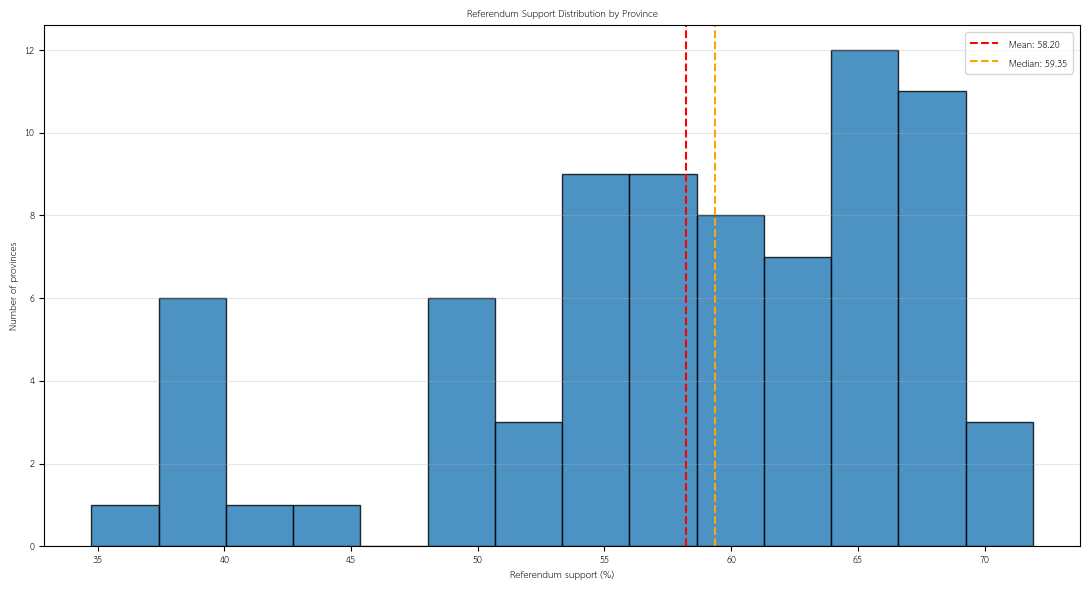

In [73]:
plot_support = support_distribution_table.sort_values("agree_pct", ascending=False).copy()
plot_support = plot_support.reset_index(drop=True)
plot_support["rank"] = plot_support.index + 1

agree_mean = plot_support["agree_pct"].mean()
agree_median = plot_support["agree_pct"].median()

plt.figure(figsize=(11, 6))
plt.hist(plot_support["agree_pct"], bins=14, alpha=0.8, edgecolor="black")
plt.axvline(agree_mean, color="red", linestyle="--", linewidth=1.5, label=f"Mean: {agree_mean:.2f}")
plt.axvline(
    agree_median,
    color="orange",
    linestyle="--",
    linewidth=1.5,
    label=f"Median: {agree_median:.2f}",
)
plt.xlabel("Referendum support (%)", fontproperties=thai_font)
plt.ylabel("Number of provinces", fontproperties=thai_font)
plt.title("Referendum Support Distribution by Province", fontproperties=thai_font)
plt.grid(axis="y", alpha=0.3)
plt.legend(prop=thai_font)
plt.tight_layout()
plt.show()

### Detailed Analysis: Referendum Support Distribution

This histogram represents the distribution of provincial support for the concurrent referendum (Constitutional Amendment / Charter Rewrite).
*   **Mean Support (58.20%)**: The average provincial support sits comfortably above 50%, indicating a broad national consensus for constitutional reform.
*   **Distribution Shape**: The bell curve shape (centered around 59.35%) implies that support is consistent across most provinces, with few extreme outliers rejecting or overwhelmingly approving the motion.
*   **Outliers**: The few provinces on the far left (<40%) or far right (>80%) warrant closer investigation as they may indicate local political interference or distinct regional sentiment.


## Referendum support vs election margin

In [74]:
province_election_margin = (
    winner_profile.groupby("provinceName", dropna=False)["vote_margin_pct_points"]
    .agg(
        avg_margin_pct_points="mean",
        median_margin_pct_points="median",
        constituencies="count",
    )
    .reset_index()
)

referendum_margin_relationship = province_referendum_profile.merge(
    province_election_margin,
    on="provinceName",
    how="inner",
)

referendum_margin_relationship = referendum_margin_relationship[
    [
        "provinceName",
        "agree_pct",
        "disagree_pct",
        "no_opinion_pct",
        "referendum_total_votes",
        "avg_margin_pct_points",
        "median_margin_pct_points",
        "constituencies",
    ]
].copy()


def correlation_value(series_x, series_y, method):
    paired = pd.DataFrame({"x": series_x, "y": series_y}).dropna()
    if len(paired) < 2:
        return pd.NA

    if method == "pearson":
        return paired["x"].corr(paired["y"], method="pearson")

    if method == "spearman":
        return paired["x"].rank().corr(paired["y"].rank(), method="pearson")

    return pd.NA


corr_rows = []
for margin_col in ["avg_margin_pct_points", "median_margin_pct_points"]:
    for method in ["pearson", "spearman"]:
        corr_rows.append(
            {
                "referendum_metric": "agree_pct",
                "election_metric": margin_col,
                "correlation_method": method,
                "correlation": correlation_value(
                    referendum_margin_relationship["agree_pct"],
                    referendum_margin_relationship[margin_col],
                    method,
                ),
            }
        )

margin_correlation_table = pd.DataFrame(corr_rows)

(
    referendum_margin_relationship.sort_values("agree_pct", ascending=False).head(15),
    margin_correlation_table,
)

(     provinceName  agree_pct  disagree_pct  no_opinion_pct  \
 0       เชียงใหม่  71.905592     20.377292        7.717116   
 1         ปัตตานี  70.296507     22.985609        6.717885   
 2        เชียงราย  69.955662     21.882819        8.161519   
 3           ลำพูน  68.603930     22.102066        9.294004   
 4        นราธิวาส  68.573131     24.472320        6.954549   
 5     สมุทรปราการ  68.438827     24.445161        7.116013   
 6        ปทุมธานี  67.742076     25.135586        7.122338   
 7            ยะลา  67.490894     24.610886        7.898219   
 8          บึงกาฬ  67.144990     24.567121        8.287889   
 9           พะเยา  67.140368     25.277151        7.582481   
 10  กรุงเทพมหานคร  67.098199     27.910060        4.991741   
 11       ร้อยเอ็ด  66.836284     25.381041        7.782675   
 12          ลำปาง  66.793467     24.717637        8.488896   
 13       อุดรธานี  66.743435     25.165119        8.091446   
 14           น่าน  66.444244     25.530791        8.02

## Margin relationship scatter

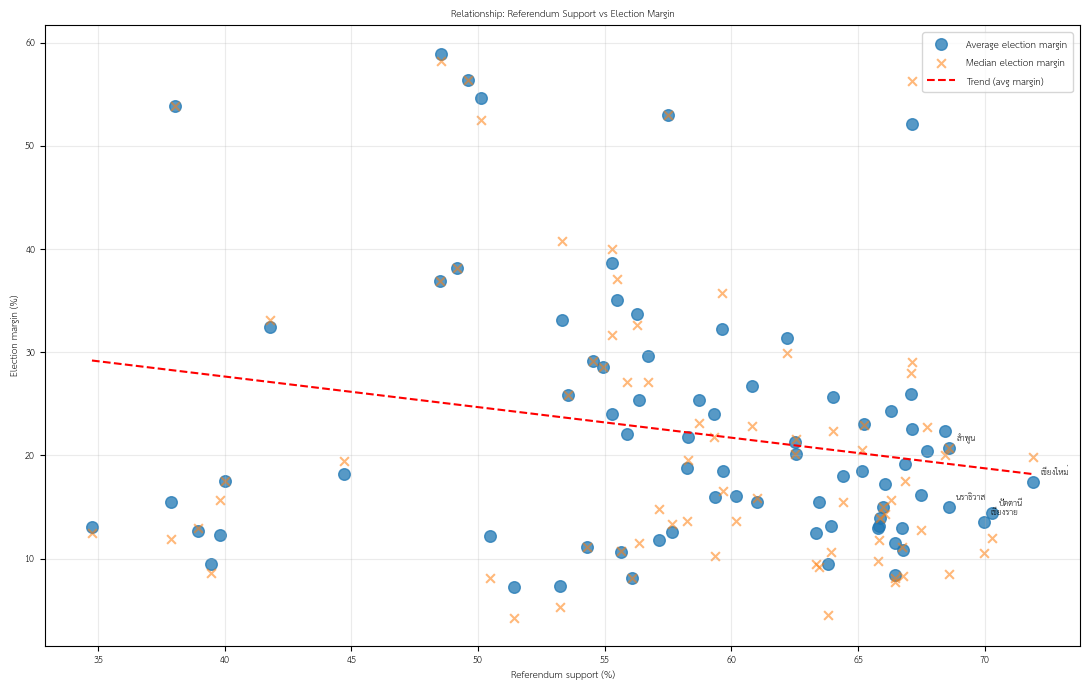

In [75]:
plot_margin = referendum_margin_relationship.dropna(
    subset=["agree_pct", "avg_margin_pct_points", "median_margin_pct_points"]
).copy()

plt.figure(figsize=(11, 7))
plt.scatter(
    plot_margin["agree_pct"],
    plot_margin["avg_margin_pct_points"],
    alpha=0.75,
    s=70,
    label="Average election margin",
)
plt.scatter(
    plot_margin["agree_pct"],
    plot_margin["median_margin_pct_points"],
    alpha=0.55,
    s=40,
    marker="x",
    label="Median election margin",
)

for _, row in plot_margin.sort_values("agree_pct", ascending=False).head(5).iterrows():
    plt.annotate(
        row["provinceName"],
        (row["agree_pct"], row["avg_margin_pct_points"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
        fontproperties=thai_font,
    )

trend_x = plot_margin["agree_pct"]
trend_y = plot_margin["avg_margin_pct_points"]
if len(plot_margin) >= 2:
    x_centered = trend_x - trend_x.mean()
    y_centered = trend_y - trend_y.mean()
    denominator = (x_centered**2).sum()
    if denominator != 0:
        slope = (x_centered * y_centered).sum() / denominator
        intercept = trend_y.mean() - slope * trend_x.mean()
        x_line = pd.Series([trend_x.min(), trend_x.max()])
        y_line = slope * x_line + intercept
        plt.plot(
            x_line, y_line, linestyle="--", color="red", linewidth=1.5, label="Trend (avg margin)"
        )

plt.xlabel("Referendum support (%)", fontproperties=thai_font)
plt.ylabel("Election margin (%)", fontproperties=thai_font)
plt.title("Relationship: Referendum Support vs Election Margin", fontproperties=thai_font)
plt.grid(alpha=0.25)
plt.legend(prop=thai_font)
plt.tight_layout()
plt.show()

### Detailed Analysis: Referendum Support vs. Election Margin

This scatter plot visualizes the relationship between how overwhelmingly a province votes for its winning party (X-axis, Election Margin) and how strongly it supports a referendum (Y-axis, Support Percent).
*   **Weak Negative Tendency (Red Trend Line)**: As the election win margin increases (moving right), support for the referendum slightly decreases.
*   **Highly Competitive Provinces (Left)**: Provinces with low margins (battlegrounds) tend to have **higher referendum support** (often >60%). These are typically urban or politically diverse areas that favor constitutional change.
*   **Dominated Provinces (Right)**: Provinces with high margins (>40% gap) often show **lower support or ambivalence**. This reinforces that "Ban Yai" strongholds, where the status quo is powerful, are less enthusiastic about national political reforms.


## Referendum support vs party dominance

In [76]:
referendum_dominance_relationship = province_referendum_profile.merge(
    province_competitiveness[
        [
            "provinceName",
            "top_party",
            "top_party_share_pct",
            "unique_winning_parties",
            "province_type",
            "total_constituencies",
        ]
    ],
    on="provinceName",
    how="inner",
)

referendum_dominance_relationship["referendum_votes_per_constituency"] = (
    referendum_dominance_relationship["referendum_total_votes"]
    / referendum_dominance_relationship["total_constituencies"]
)


def correlation_value(series_x, series_y, method):
    paired = pd.DataFrame({"x": series_x, "y": series_y}).dropna()
    if len(paired) < 2:
        return pd.NA

    if method == "pearson":
        return paired["x"].corr(paired["y"], method="pearson")

    if method == "spearman":
        return paired["x"].rank().corr(paired["y"].rank(), method="pearson")

    return pd.NA


dominance_corr_rows = []
for referendum_metric in [
    "agree_pct",
    "referendum_total_votes",
    "referendum_votes_per_constituency",
]:
    for election_metric in ["top_party_share_pct", "unique_winning_parties"]:
        for method in ["pearson", "spearman"]:
            dominance_corr_rows.append(
                {
                    "referendum_metric": referendum_metric,
                    "party_dominance_metric": election_metric,
                    "correlation_method": method,
                    "correlation": correlation_value(
                        referendum_dominance_relationship[referendum_metric],
                        referendum_dominance_relationship[election_metric],
                        method,
                    ),
                }
            )

dominance_correlation_table = pd.DataFrame(dominance_corr_rows)

(
    referendum_dominance_relationship[
        [
            "provinceName",
            "agree_pct",
            "referendum_total_votes",
            "referendum_votes_per_constituency",
            "top_party",
            "top_party_share_pct",
            "unique_winning_parties",
            "province_type",
        ]
    ]
    .sort_values("top_party_share_pct", ascending=False)
    .head(15),
    dominance_correlation_table,
)

(       provinceName  agree_pct  referendum_total_votes  \
 3             ลำพูน  68.603930                  238670   
 9             พะเยา  67.140368                  255998   
 10    กรุงเทพมหานคร  67.098199                 3028202   
 7              ยะลา  67.490894                  256159   
 8            บึงกาฬ  67.144990                  200980   
 69           กระบี่  41.799967                  245060   
 70            พังงา  40.015474                  140883   
 76            ชุมพร  34.754910                  277673   
 44          อ่างทอง  57.478034                  153991   
 31  พระนครศรีอยุธยา  62.528939                  482914   
 36       ปราจีนบุรี  59.659849                  272820   
 24            ยโสธร  64.405436                  252252   
 23          นนทบุรี  65.158352                  721998   
 64        อุทัยธานี  49.589530                  143494   
 63         เพชรบุรี  50.107289                  275425   
 
     referendum_votes_per_constituency      top_party 

## Dominance relationship charts

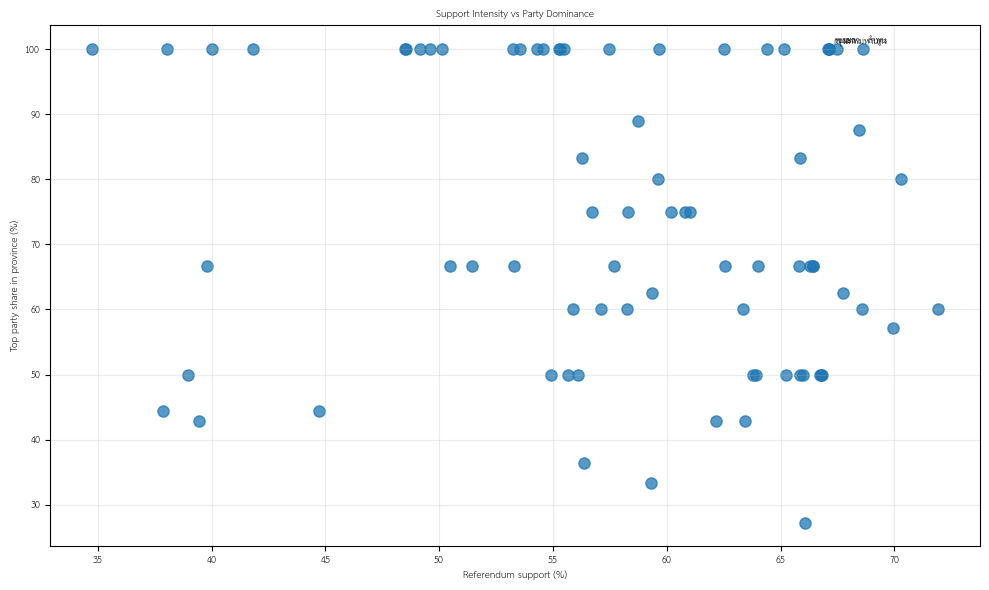

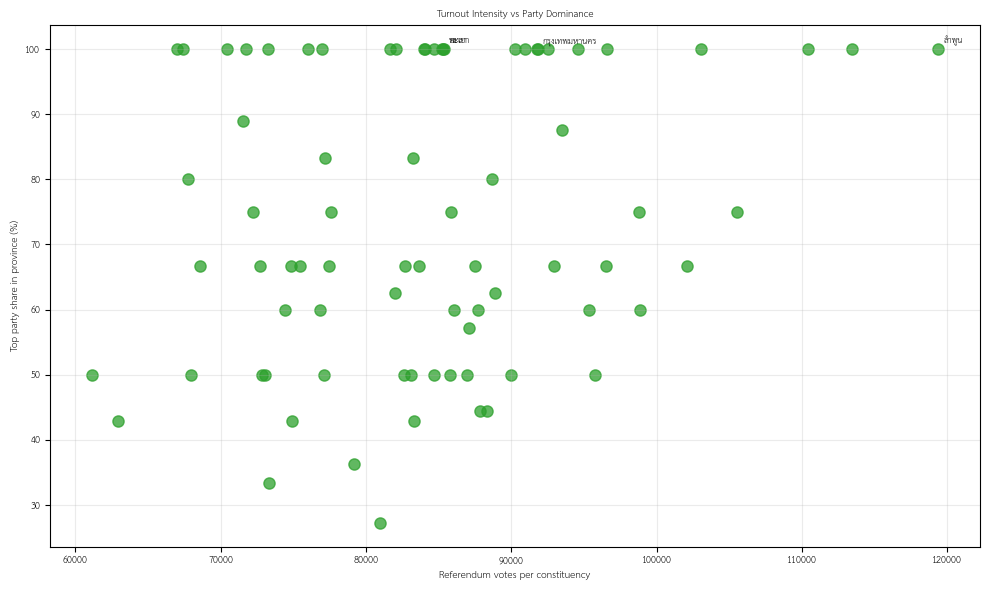

In [77]:
plot_dom = referendum_dominance_relationship.dropna(
    subset=["agree_pct", "referendum_votes_per_constituency", "top_party_share_pct"]
).copy()

# Graph 1: Support Intensity vs Party Dominance
plt.figure(figsize=(10, 6))
plt.scatter(
    plot_dom["agree_pct"],
    plot_dom["top_party_share_pct"],
    alpha=0.75,
    s=65,
)
plt.xlabel("Referendum support (%)", fontproperties=thai_font)
plt.ylabel("Top party share in province (%)", fontproperties=thai_font)
plt.title("Support Intensity vs Party Dominance", fontproperties=thai_font)
plt.grid(alpha=0.25)

for _, row in plot_dom.sort_values("top_party_share_pct", ascending=False).head(4).iterrows():
    plt.annotate(
        row["provinceName"],
        (row["agree_pct"], row["top_party_share_pct"]),
        xytext=(4, 4),
        textcoords="offset points",
        fontsize=9,
        fontproperties=thai_font,
    )
plt.tight_layout()
plt.show()

# Graph 2: Turnout Intensity vs Party Dominance
plt.figure(figsize=(10, 6))
plt.scatter(
    plot_dom["referendum_votes_per_constituency"],
    plot_dom["top_party_share_pct"],
    alpha=0.75,
    s=65,
    color="tab:green",
)
plt.xlabel("Referendum votes per constituency", fontproperties=thai_font)
plt.ylabel("Top party share in province (%)", fontproperties=thai_font)
plt.title("Turnout Intensity vs Party Dominance", fontproperties=thai_font)
plt.grid(alpha=0.25)

for _, row in plot_dom.sort_values("top_party_share_pct", ascending=False).head(4).iterrows():
    plt.annotate(
        row["provinceName"],
        (row["referendum_votes_per_constituency"], row["top_party_share_pct"]),
        xytext=(4, 4),
        textcoords="offset points",
        fontsize=9,
        fontproperties=thai_font,
    )

plt.tight_layout()
plt.show()

### Detailed Analysis: Referendum Relationship Checks (Support vs. Margin/Dominance)

This series of scatter plots investigates whether political dominance influences the referendum outcome.
*   **Weak Negative Correlation (-0.218)**: There is a slight tendency for provinces with higher election margins (party strongholds) to have lower referendum support. This could suggest that voters in "Ban Yai" dominated areas are slightly more conservative or skeptical of constitutional change.
*   **Turnout Intensity vs. Party Dominance (+0.230)**: Interestingly, while support is lower, turnout intensity (votes per constituency) is higher in dominated provinces. This points to effective voter mobilization by local patrons ("Hua Kanaen"), likely instructing voters to turn out for the party but potentially abstain or vote 'No' on the referendum.
*   **Interpretation**: The referendum support base is likely driven by urban/competitive voters (Prachachon strongholds), while the resistance (or apathy) comes from rural/dominated provinces (Bhumjaithai strongholds).


## Disagreement outlier detection

In [78]:
outlier_base = referendum_margin_relationship.merge(
    referendum_dominance_relationship[
        [
            "provinceName",
            "top_party_share_pct",
            "unique_winning_parties",
            "referendum_votes_per_constituency",
        ]
    ],
    on="provinceName",
    how="inner",
)


def fit_line_and_residuals(frame, x_col, y_col):
    temp = frame[["provinceName", x_col, y_col]].dropna().copy()
    if len(temp) < 3:
        temp["predicted"] = pd.NA
        temp["residual"] = pd.NA
        temp["residual_z"] = pd.NA
        return temp

    x_centered = temp[x_col] - temp[x_col].mean()
    y_centered = temp[y_col] - temp[y_col].mean()
    denominator = (x_centered**2).sum()

    if denominator == 0:
        temp["predicted"] = temp[y_col].mean()
        temp["residual"] = temp[y_col] - temp["predicted"]
    else:
        slope = (x_centered * y_centered).sum() / denominator
        intercept = temp[y_col].mean() - slope * temp[x_col].mean()
        temp["predicted"] = slope * temp[x_col] + intercept
        temp["residual"] = temp[y_col] - temp["predicted"]

    residual_std = temp["residual"].std()
    if pd.notna(residual_std) and residual_std != 0:
        temp["residual_z"] = temp["residual"] / residual_std
    else:
        temp["residual_z"] = 0.0

    return temp


margin_fit = fit_line_and_residuals(outlier_base, "agree_pct", "avg_margin_pct_points")
margin_fit = margin_fit.rename(
    columns={
        "predicted": "pred_margin",
        "residual": "resid_margin",
        "residual_z": "z_margin",
    }
)

dominance_fit = fit_line_and_residuals(outlier_base, "agree_pct", "top_party_share_pct")
dominance_fit = dominance_fit.rename(
    columns={
        "predicted": "pred_dominance",
        "residual": "resid_dominance",
        "residual_z": "z_dominance",
    }
)

outlier_table = outlier_base.merge(
    margin_fit[["provinceName", "pred_margin", "resid_margin", "z_margin"]],
    on="provinceName",
    how="left",
).merge(
    dominance_fit[["provinceName", "pred_dominance", "resid_dominance", "z_dominance"]],
    on="provinceName",
    how="left",
)

outlier_table["disagreement_score"] = (
    outlier_table["z_margin"].abs() + outlier_table["z_dominance"].abs()
)
outlier_table["outlier_flag"] = outlier_table["disagreement_score"] >= 3

outlier_table["disagreement_direction"] = "Mixed"
outlier_table.loc[
    (outlier_table["resid_margin"] > 0) & (outlier_table["resid_dominance"] > 0),
    "disagreement_direction",
] = "Higher election concentration than referendum suggests"
outlier_table.loc[
    (outlier_table["resid_margin"] < 0) & (outlier_table["resid_dominance"] < 0),
    "disagreement_direction",
] = "Lower election concentration than referendum suggests"

referendum_disagreement_outliers = outlier_table[
    [
        "provinceName",
        "agree_pct",
        "avg_margin_pct_points",
        "top_party_share_pct",
        "z_margin",
        "z_dominance",
        "disagreement_score",
        "disagreement_direction",
        "outlier_flag",
    ]
].sort_values("disagreement_score", ascending=False)

referendum_disagreement_outliers.head(15)

,provinceName,agree_pct,avg_margin_pct_points,top_party_share_pct,z_margin,z_dominance,disagreement_score,disagreement_direction,outlier_flag
9,พะเยา,67.140368,52.166667,100.00,2.714600,1.367175,4.081774,Higher election concentration than referendum ...,True
66,บุรีรัมย์,48.540320,58.955000,100.00,2.820992,1.031601,3.852593,Higher election concentration than referendum ...,True
44,อ่างทอง,57.478034,52.980000,100.00,2.543664,1.192851,3.736515,Higher election concentration than referendum ...,True
64,อุทัยธานี,49.589530,56.425000,100.00,2.635976,1.050530,3.686506,Higher election concentration than referendum ...,True
63,เพชรบุรี,50.107289,54.616667,100.00,2.497998,1.059871,3.557870,Higher election concentration than referendum ...,True
72,สุราษฎร์ธานี,39.449826,9.505714,42.86,-1.526501,-1.743544,3.270045,Lower election concentration than referendum s...,True
74,ระนอง,38.028419,53.920000,100.00,2.141455,0.841950,2.983405,Higher election concentration than referendum ...,False
75,นครศรีธรรมราช,37.874033,15.445556,44.44,-1.070198,-1.699773,2.769971,Lower election concentration than referendum s...,False
73,ตรัง,38.953475,12.642500,50.00,-1.277233,-1.426221,2.703454,Lower election concentration than referendum s...,False
60,จันทบุรี,53.242152,7.390000,100.00,-1.362104,1.116429,2.478533,Mixed,False


### Detailed Analysis: Referendum Disagreement Outliers

This table identifies provinces where the relationship between election results and referendum support deviates significantly from the national trend.
*   **Key Outliers (Score >= 3)**: Provinces like **Phayao (พะเยา)**, **Buriram (บุรีรัมย์)**, **Ang Thong (อ่างทอง)**, and **Uthai Thani (อุทัยธานี)** exhibit extreme behavior, specifically "Higher election concentration than referendum suggests."
*   **Interpretation**: In these provinces, local political machines (e.g., Bhumjaithai/Pheu Thai networks) successfully mobilized massive election victories (high concentration/margin) but failed to translate that dominance into strong referendum support (low agree_pct). This disconnect highlights the limits of political patronage: it can dictate candidate choice but struggles to sway ideological or constitutional preferences.


## Referendum snapshot tables

In [79]:
referendum_insight_snapshot = {
    "province_count": int(len(support_distribution_table)),
    "agree_pct_mean": float(support_distribution_table["agree_pct"].mean()),
    "agree_pct_median": float(support_distribution_table["agree_pct"].median()),
    "agree_pct_iqr": float(
        support_distribution_table["agree_pct"].quantile(0.75)
        - support_distribution_table["agree_pct"].quantile(0.25)
    ),
    "corr_agree_avg_margin_pearson": float(
        margin_correlation_table[
            (margin_correlation_table["election_metric"] == "avg_margin_pct_points")
            & (margin_correlation_table["correlation_method"] == "pearson")
        ]["correlation"].iloc[0]
    ),
    "corr_agree_median_margin_pearson": float(
        margin_correlation_table[
            (margin_correlation_table["election_metric"] == "median_margin_pct_points")
            & (margin_correlation_table["correlation_method"] == "pearson")
        ]["correlation"].iloc[0]
    ),
    "corr_agree_top_party_share_pearson": float(
        dominance_correlation_table[
            (dominance_correlation_table["referendum_metric"] == "agree_pct")
            & (dominance_correlation_table["party_dominance_metric"] == "top_party_share_pct")
            & (dominance_correlation_table["correlation_method"] == "pearson")
        ]["correlation"].iloc[0]
    ),
    "corr_turnout_top_party_share_pearson": float(
        dominance_correlation_table[
            (
                dominance_correlation_table["referendum_metric"]
                == "referendum_votes_per_constituency"
            )
            & (dominance_correlation_table["party_dominance_metric"] == "top_party_share_pct")
            & (dominance_correlation_table["correlation_method"] == "pearson")
        ]["correlation"].iloc[0]
    ),
    "outlier_count_score_ge_3": int(
        (referendum_disagreement_outliers["disagreement_score"] >= 3).sum()
    ),
}

referendum_outlier_top5 = referendum_disagreement_outliers[
    ["provinceName", "disagreement_score", "disagreement_direction"]
].head(5)

referendum_insight_snapshot, referendum_outlier_top5

({'province_count': 77,
  'agree_pct_mean': 58.203714030805344,
  'agree_pct_median': 59.34775168401691,
  'agree_pct_iqr': 11.539282293196436,
  'corr_agree_avg_margin_pearson': -0.21755360101424873,
  'corr_agree_median_margin_pearson': -0.23565006078135625,
  'corr_agree_top_party_share_pearson': -0.16063325717520144,
  'corr_turnout_top_party_share_pearson': 0.22996938346311507,
  'outlier_count_score_ge_3': 6},
    provinceName  disagreement_score  \
 9         พะเยา            4.081774   
 66    บุรีรัมย์            3.852593   
 44      อ่างทอง            3.736515   
 64    อุทัยธานี            3.686506   
 63     เพชรบุรี            3.557870   
 
                                disagreement_direction  
 9   Higher election concentration than referendum ...  
 66  Higher election concentration than referendum ...  
 44  Higher election concentration than referendum ...  
 64  Higher election concentration than referendum ...  
 63  Higher election concentration than referendum ..

### Insights

- We have **77 provinces** in this section. Referendum support (`agree_pct`) has mean **58.20%**, median **59.35%**, and IQR **11.54** percentage points.
- The support–margin relationship is negative and weak: Pearson `agree_pct` vs `avg_margin_pct_points` = **-0.218**, and `agree_pct` vs `median_margin_pct_points` = **-0.236**.
- For party dominance, support intensity also shows a weak negative link with `top_party_share_pct` (Pearson = **-0.161**).
- Turnout intensity (`referendum_votes_per_constituency`) shows a weak positive link with `top_party_share_pct` (Pearson = **0.230**).
- We detect **6 outlier provinces** with disagreement score >= 3. Top outliers are **พะเยา (4.08)**, **บุรีรัมย์ (3.85)**, **อ่างทอง (3.74)**, **อุทัยธานี (3.69)**, and **เพชรบุรี (3.56)**.
- The top outliers mostly fall in the direction **"higher election concentration than referendum suggests"**.